In [1]:
import cv2
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import chainercv
from chainercv.datasets import VOCSemanticSegmentationDataset
from chainer.datasets import TransformDataset
from chainercv.evaluations import eval_semantic_segmentation
import os.path
from os import path
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import random
import glob
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import copy
use_cuda = torch.cuda.is_available()
device =  torch.device("cuda" if use_cuda else "cpu")
from PIL import Image
import torch.utils.data as data
from torch.utils.data import DataLoader

## Create Dataset

In [3]:
class DataLoaderSegmentation(data.Dataset):
        def __init__(self, split):
            super(DataLoaderSegmentation, self).__init__()
        
            if split not in ['train', 'val', 'test']:
                raise ValueError('please pick split from \'train\', \'test\', or \'val\'')
            
            dir_path = os.getcwd()
            self.split = split
            self.image_paths = os.path.join(dir_path, 'data', 'tas500v1.1', 'tas500v1.1', split)
            if self.split != 'test':
                self.label_paths = os.path.join(dir_path, 'data', 'tas500v1.1', 'tas500v1.1', split + '_labels_ids')
                self.labels = os.listdir(self.label_paths)
            self.files = os.listdir(self.image_paths)
            
        def __len__(self):
            return len(self.files)
        
        def __getitem__(self, idx):
            image_name = self.files[idx]
            
            image = Image.open(os.path.join(self.image_paths, image_name)).convert('RGB')

            if self.split != 'test':
                label_name = self.labels[idx]
                mask  = Image.open(os.path.join(self.label_paths, label_name))
                x, y = self.transformData(image, mask)
                y = np.where(y == 255, 23, y)
                x, y = torch.from_numpy(x).float(), torch.from_numpy(y).long()
                x = torch.permute(x, (2, 0, 1))
                return x, y
            else:
                x, y = self.transformData(image, None)
                x = torch.from_numpy(x).float()
                x = torch.permute(x, (2, 0, 1))
                return x
    
        def transformData(self, image, mask=None):
            # Random crop
            i, j, h, w = transforms.RandomCrop.get_params(
                image, output_size=(512,512))
            image = TF.crop(image, i, j, h, w)
            if mask is not None:
                mask = TF.crop(mask, i, j, h, w)

            # Random horizontal flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                if mask is not None:
                    mask = TF.hflip(mask)

            # Random Vertical Flip
            if random.random() > 0.5:
                image = TF.vflip(image)
                if mask is not None:
                    mask = TF.vflip(mask)

            image = np.array(image)
            if mask is not None:
                mask  = np.array(mask)
            
            image = image[:, :, ::-1].copy()
            
            return image, mask

In [4]:
train_data = DataLoaderSegmentation('train')

In [5]:
def find_image():
    trunk_label = 10
    bush_label = 4
    person_label = 20
    animal_label = 21
    count = 0
    max_count = 3
    for i in range(len(train_data)):
        tmp_count = np.unique(train_data[i][1], return_counts=True)
#         print(tmp_count)
        if person_label in tmp_count[0]:
#             if tmp_count[1][i] > 100
            if count == max_count:
                break
            else:
                img, label = train_data[i]
                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)
                plt.title('Image ' + str(i))
                ax.imshow(np.rollaxis(img.numpy().astype(int), 0, 0))
                count += 1

# find_image()

palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

# Some relevant images
img_113, seg_img_113 = train_data[113]
img_28, seg_img_28 = train_data[28]
img_354, seg_img_354 = train_data[354]

def colorize_mask(mask):
    new_mask = Image.fromarray(mask.numpy().astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)
                      
    return new_mask

def add_img_plot(fig, index, img, title, sub_plot_id):
    ax = fig.add_subplot(sub_plot_id[0],sub_plot_id[1],sub_plot_id[2])
    plt.title(title + str(index))
    ax.imshow(img)

    
fig = plt.figure(figsize=(10,10))

# person image
add_img_plot(fig, 113, np.rollaxis(img_113.numpy().astype(int), 0, 3), 'Image ', [3,2,1])
add_img_plot(fig, 113, colorize_mask(seg_img_113), 'Segmented Image ', [3,2,2])
# car image
add_img_plot(fig, 28, np.rollaxis(img_28.numpy().astype(int), 0, 3), 'Image ', [3,2,3])
add_img_plot(fig, 28, colorize_mask(seg_img_28), 'Segmented Image ', [3,2,4])
# animal image
add_img_plot(fig, 354, np.rollaxis(img_354.numpy().astype(int), 0, 3), 'Image ', [3,2,5])
add_img_plot(fig, 354, colorize_mask(seg_img_354), 'Segmented Image ', [3,2,6])

In [5]:
if device == 'cpu':
    train_loader = DataLoader(train_data, batch_size=5, shuffle=True, num_workers=0)
else:
    train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)

In [4]:
class Net(nn.Module):
    def __init__(self, criterion=None):
        super(Net, self).__init__()
        self.criterion = criterion        
        self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        self.conv1 = nn.Conv2d(1312, 512, 3, 1)
        self.conv2 = nn.Conv2d(512, 24, 3, 1)
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(24)
        self.dropout1 = nn.Dropout2d()
    def forward(self, inp, gts=None): 
        output_size = (inp.size()[2],inp.size()[3])
        # Encoder
        for idx, layer in enumerate(self.mobilenet_v2.features):
            if idx == 0:
                x = layer(inp)
            elif idx == 5:
                skip_connection_1 = x
                x = layer(x)
            else:
                x = layer(x)
        x = F.interpolate(x, size=(skip_connection_1.shape[2], skip_connection_1.shape[3]))
        x = torch.cat([skip_connection_1, x], 1)
        # Decoder Layer 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = F.interpolate(x, size=(output_size[0] + 2, output_size[1] + 2))
        # Decoder Layer 2
        x = self.conv2(x)
        lfinal = self.bn2(x)

        
        if self.training:
            # Return the loss if in training mode
            return self.criterion(lfinal, gts)
        else:
            # Return the actual prediction otherwise
            return lfinal

In [20]:
# import torch.backends.cudnn as cudnn

checkpoint = None
batch_size = 3
iterations = 65000
weight_decay = 5e-4
momentum = 0.5

# cudnn.benchmark = True

def adjust_learning_rate(optimizer, lr_to):
    for g in optimizer.param_groups:
        g['lr'] = g['lr']*lr_to

def save_checkpoint(epoch, model, optimizer, scheduler):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param model: model
    :param optimizer: optimizer
    :param base_type: The base network type
    """
    state = {'epoch': epoch,
             'model': model,
             'optimizer': optimizer,
             'scheduler': scheduler}
    if scheduler == None:
        filename = 'checkpoint_mobilenet_v2.pth.tar'
    else:
        filename = 'checkpoint_mobilenet_v2_scheduler.pth.tar'
    torch.save(state, filename)

def train_mobilenet_v2(lr_type):
    """
    Training.
    """
    global start_epoch, label_map, epoch, checkpoint, delay_lr_at
    
    train_dataset = DataLoaderSegmentation('train')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    if lr_type == 'original_scheduler':
        lr = 1e-1
        decay_lr_at = [45000, 55000] # decay learning rate after this many iterations
        decay_lr_to = 0.1
    elif lr_type == 'pytorch_scheduler':
        lr = 1e-3
    else:
        raise NotImplementedError
        
    epochs = iterations // (len(train_dataset) // batch_size)
    
    if lr_type == 'original_scheduler':
        decay_lr_at = [it // (len(train_dataset) // batch_size) for it in decay_lr_at]
        print("Epochs to decay learning rate:", decay_lr_at)
    
    if checkpoint is None:
        start_epoch = 0
        model = trained_net = Net().to(device)
        
        optimizer = torch.optim.SGD(model.parameters(),
                               lr=lr,
                               weight_decay=weight_decay,
                               momentum=momentum,
                               nesterov=False)
        if lr_type == 'pytorch_scheduler':
            raise NotImplementedError
    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']
        if lr_type == 'pytorch_scheduler':
            raise NotImplementedError
        
    model.criterion = nn.CrossEntropyLoss(ignore_index=-1)
    
    loss_graph = []
    
    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)
    
    for epoch in range(start_epoch, epochs):
        
        if lr_type == 'original_scheduler':
            if epoch in decay_lr_at:
                adjust_learning_rate(optimizer, decay_lr_to)
                for g in optimizer.param_groups:
                    print("Optimizer learning rate changed to {}".format(g['lr']))

        loss = train_model(train_loader=train_loader, model=model,loss_graph=loss_graph, epoch=epoch, device=device, optimizer=optimizer)
        if lr_type == 'pytorch_scheduler':
            raise NotImplementedError
        
        if lr_type == 'original_scheduler':
            save_checkpoint(epoch, model, optimizer, scheduler=None)
        else:
            save_checkpoint(epoch, model, optimizer, scheduler)
            
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for trained  net')
        ax.plot(loss_graph, label='training loss')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}".format(epoch, loss))

def train_model(train_loader, model, optimizer, epoch, device, loss_graph):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        img, gt_seg_img = data.to(device), target.to(device)
        
        main_loss = model(img, gts=gt_seg_img)
        
        loss_graph.append(main_loss.item())
        
        print(main_loss.item())
        
        optimizer.zero_grad()
        main_loss.backward()
        optimizer.step()

    return main_loss

In [21]:
torch.cuda.empty_cache()
train_mobilenet_v2('original_scheduler')

Epochs to decay learning rate: [308, 376]
3.5000030994415283
3.3183467388153076
3.2410099506378174
2.7446229457855225
2.737217664718628
2.446399211883545
2.785540819168091
2.4957244396209717
3.2289466857910156
2.400601625442505
2.286227226257324
2.6073720455169678
3.080946207046509
2.55889892578125
2.111574649810791
1.9621468782424927
2.1345341205596924
2.392277956008911
2.0144035816192627
2.8925297260284424
2.1075689792633057
2.45620059967041
2.6787633895874023
2.0971696376800537
2.0044467449188232
2.9407689571380615
1.9958683252334595
2.302414894104004
2.197723150253296
1.9097782373428345
2.3795831203460693
2.51605486869812
2.7892062664031982
2.4540505409240723
2.1171069145202637
2.029461622238159
2.2924749851226807
2.5397863388061523
2.197309732437134
2.671104669570923
2.2153196334838867
2.2720932960510254
2.055837631225586
1.8817170858383179
2.3442223072052
1.9829643964767456
1.7463010549545288
1.7210437059402466
2.3517258167266846
2.325059652328491
2.067288637161255
1.799793243408

1.1068223714828491
1.9628483057022095
1.0902985334396362
1.158218264579773
1.2454224824905396
1.2614750862121582
1.4869930744171143
Epoch: 2 Loss: 1.4869930744171143
1.5274300575256348
1.193045735359192
0.8873000144958496
1.1871477365493774
1.5065304040908813
1.3685026168823242
1.4351110458374023
1.185973048210144
1.0246597528457642
1.2138442993164062
1.610964298248291
1.981993317604065
1.6318007707595825
1.329753041267395
1.5066027641296387
1.3395929336547852
2.092000722885132
1.6941040754318237
1.28049898147583
1.1283961534500122
1.5653952360153198
1.4901150465011597
1.571640133857727
1.2642977237701416
1.4438997507095337
1.105136513710022
1.016656517982483
1.2262917757034302
1.1238932609558105
1.5629196166992188
1.4142131805419922
1.560935378074646
1.4953035116195679
1.2949960231781006
1.1243363618850708
1.2315036058425903
1.527364730834961
1.6271872520446777
1.4147357940673828
1.1505972146987915
1.1775811910629272
1.2569279670715332
1.0434584617614746
1.696928858757019
1.1512103080

1.0231072902679443
1.1547602415084839
1.6931606531143188
1.0047584772109985
1.7647982835769653
0.8923349976539612
1.0367790460586548
1.44865882396698
0.9745073914527893
1.183333396911621
1.418716549873352
1.129534363746643
1.117061734199524
1.592018723487854
1.1692442893981934
Epoch: 5 Loss: 1.1692442893981934
0.9771742820739746
0.9102292656898499
1.517748236656189
0.9501851201057434
0.8018059730529785
1.1310824155807495
0.7011473774909973
1.6439471244812012
1.0415178537368774
0.8882333636283875
0.9865859150886536
1.037484049797058
0.8181996941566467
1.149267315864563
2.1205899715423584
0.8664200305938721
1.4659589529037476
1.126326322555542
1.1543688774108887
1.6855086088180542
1.2637338638305664
1.6009020805358887
1.0297542810440063
1.4147368669509888
1.3339613676071167
1.2536391019821167
1.1200872659683228
0.9841856956481934
1.3551931381225586
1.8706172704696655
1.3241113424301147
1.0201843976974487
0.9346824288368225
1.0242345333099365
1.5351591110229492
1.060322880744934
1.2631558

1.7273205518722534
1.0055195093154907
1.4498814344406128
1.2834991216659546
1.5160263776779175
1.131930947303772
1.349136233329773
1.9045263528823853
0.9344286918640137
1.5380897521972656
1.1022816896438599
1.5940189361572266
0.7972546219825745
0.7119929790496826
0.7549748420715332
0.8941001296043396
0.6531111598014832
1.3613853454589844
1.0624819993972778
0.7745130658149719
1.685071349143982
0.8083491921424866
0.9878237843513489
0.6564618945121765
Epoch: 8 Loss: 0.6564618945121765
0.7287361025810242
1.1297603845596313
0.9328545928001404
1.3344465494155884
1.6535614728927612
0.9594969153404236
1.7794290781021118
1.389511227607727
0.8049108386039734
1.2982052564620972
1.2133370637893677
0.8616588711738586
1.2200008630752563
0.9492953419685364
1.782638669013977
0.9552766680717468
1.080956220626831
1.0545176267623901
1.092476487159729
1.062013030052185
1.3510276079177856
1.6471589803695679
1.1302592754364014
1.13192880153656
1.0870962142944336
1.1092106103897095
1.1833120584487915
1.05542

1.4397636651992798
1.0284647941589355
1.2754548788070679
1.5796173810958862
1.19434654712677
1.0683842897415161
1.088769555091858
0.8881035447120667
1.7298656702041626
1.3781746625900269
0.6994283199310303
1.3763232231140137
0.7158579230308533
1.0259324312210083
0.7423990368843079
1.3430017232894897
0.9711628556251526
1.123217225074768
1.3355447053909302
1.0871566534042358
1.027154803276062
1.1498322486877441
0.9635993838310242
1.4667906761169434
0.8397144675254822
0.7288115620613098
0.6354643702507019
0.9259786605834961
1.128552794456482
1.0563163757324219
0.8523300290107727
1.7769650220870972
2.525935411453247
1.5193339586257935
Epoch: 11 Loss: 1.5193339586257935
0.8568317294120789
1.5946578979492188
0.8641297221183777
0.878895103931427
1.300113558769226
0.6394261121749878
0.9114144444465637
1.0568522214889526
0.8508100509643555
1.1116989850997925
0.835744321346283
1.1890177726745605
0.5616846680641174
0.9653860926628113
0.8671790957450867
0.8171206116676331
1.1664419174194336
1.6312

0.7287566661834717
0.983522355556488
1.2503124475479126
0.7644917368888855
1.0467603206634521
0.6285971999168396
0.9749721884727478
0.8755608201026917
1.253667950630188
1.0298362970352173
0.7324233055114746
1.583306908607483
0.9762207865715027
0.8841462731361389
1.452524185180664
0.9841022491455078
1.2694251537322998
1.4472713470458984
1.157970905303955
0.9668612480163574
0.8626249432563782
0.6669642329216003
1.1858183145523071
0.9680399298667908
0.7703571319580078
1.1138800382614136
0.8160287737846375
1.4742398262023926
1.3654695749282837
1.2118384838104248
0.7563555836677551
0.6243165135383606
0.9461779594421387
1.0953465700149536
1.2348517179489136
1.0974496603012085
0.7316681742668152
1.6461658477783203
1.0939788818359375
0.648149311542511
1.163910984992981
1.0055350065231323
0.9707333445549011
1.5281434059143066
Epoch: 14 Loss: 1.5281434059143066
1.0352455377578735
1.2889654636383057
0.5151326060295105
0.8499290347099304
0.9213414192199707
0.7716692090034485
0.9438638687133789
0.8

0.6984161734580994
0.9741647839546204
1.0154064893722534
0.7963358759880066
1.053234338760376
0.7679983973503113
0.7511056065559387
1.0317407846450806
0.893873929977417
0.8167209029197693
0.864694356918335
0.8908082842826843
1.2685993909835815
1.2508264780044556
1.4216976165771484
0.6988237500190735
0.7213749885559082
0.5731170773506165
0.8525038361549377
0.8490710854530334
1.5914230346679688
1.1456133127212524
0.970639705657959
0.9719052314758301
1.2959831953048706
1.2104218006134033
1.247094988822937
1.927769660949707
1.216484785079956
1.8138803243637085
1.1571807861328125
1.0028935670852661
0.9401577115058899
1.0359960794448853
0.7811774611473083
0.6967841982841492
0.7287073731422424
0.7119448781013489
1.2578988075256348
1.0508321523666382
0.8456816077232361
0.7771532535552979
1.2372273206710815
1.2957044839859009
1.2263964414596558
1.1973227262496948
1.1454381942749023
1.185238003730774
1.1621001958847046
1.1698514223098755
1.1560884714126587
1.3041890859603882
0.9999588131904602
0

0.9244963526725769
1.1844326257705688
1.0886379480361938
0.4406634271144867
1.0833724737167358
0.7058871388435364
0.822163999080658
0.9099008440971375
1.2893801927566528
0.756376326084137
1.2379294633865356
1.2703442573547363
1.1027241945266724
0.6014490723609924
0.8994989991188049
0.6804578900337219
1.4148530960083008
1.057332158088684
0.7282924056053162
2.1109657287597656
0.7142565846443176
0.801646888256073
0.6249790787696838
1.3545947074890137
0.45807138085365295
0.780465841293335
0.4422277510166168
1.1246455907821655
1.690015435218811
1.5049341917037964
0.5627898573875427
0.9234085083007812
0.8168178200721741
1.0687296390533447
0.8115189671516418
1.2940224409103394
1.220521330833435
0.9285466074943542
1.197872281074524
1.227213740348816
0.6365771293640137
1.2847951650619507
0.6405733227729797
1.4657167196273804
1.773013949394226
1.5567973852157593
1.1806706190109253
0.6656937003135681
1.0561776161193848
0.6785430312156677
1.5030618906021118
0.6394209861755371
1.0753934383392334
1.

0.9195252060890198
0.9724494814872742
0.9560838341712952
0.5909315347671509
1.566627860069275
0.6053965091705322
0.9374894499778748
0.8689973950386047
0.8028888702392578
0.8093223571777344
1.1143287420272827
1.1751691102981567
1.843483567237854
1.1265608072280884
1.0433663129806519
0.8139198422431946
0.9985940456390381
0.7982396483421326
0.8061187267303467
1.0283797979354858
0.8146451115608215
1.096399188041687
1.0048187971115112
1.1583855152130127
1.1634507179260254
0.779111385345459
1.4334684610366821
0.563334047794342
1.3348604440689087
1.138484239578247
0.9664840698242188
1.681439757347107
0.871087372303009
0.9335663318634033
1.227824330329895
0.6719553470611572
1.0775715112686157
0.821258544921875
0.8527628779411316
0.8074987530708313
1.9737796783447266
0.6678745150566101
0.7593884468078613
1.2106183767318726
0.9232473373413086
1.3078504800796509
1.8279485702514648
1.2673777341842651
0.9627701640129089
0.6524510979652405
0.9277145266532898
1.125167727470398
0.8224800229072571
1.35

0.7589192390441895
1.3719874620437622
0.7544792294502258
1.353577733039856
0.7913165092468262
0.4967176914215088
0.8938674926757812
0.7192513346672058
1.3401379585266113
0.8787453174591064
1.3573311567306519
1.0840431451797485
0.6964070200920105
0.6861045956611633
0.762488067150116
0.9421480298042297
0.7125377655029297
1.0511308908462524
1.5788078308105469
0.4972420036792755
0.6153486371040344
0.7584453225135803
0.8529935479164124
0.9489606022834778
0.8828155398368835
0.7622738480567932
0.8009428977966309
0.7969643473625183
1.1257168054580688
1.588046669960022
0.7592348456382751
1.1494461297988892
1.3120465278625488
1.006562352180481
1.0647010803222656
0.9059634208679199
0.9983183741569519
1.013785719871521
1.0238136053085327
0.7740629315376282
0.5722009539604187
0.885047435760498
2.9286439418792725
1.4633899927139282
0.9912553429603577
2.1176650524139404
0.6674582958221436
0.5816411375999451
1.1374317407608032
0.8474960327148438
1.016391634941101
1.3578896522521973
1.1882742643356323


0.6599404215812683
0.9190927147865295
1.0663684606552124
1.3192740678787231
0.9336584210395813
0.9196839332580566
0.8538100123405457
1.1629289388656616
1.5805126428604126
1.0084260702133179
0.9746009707450867
1.1735676527023315
1.0405495166778564
1.0878307819366455
0.6360319256782532
0.8974912762641907
0.7692425847053528
0.7818703055381775
0.7051787972450256
1.8031744956970215
0.6255084872245789
1.1015805006027222
1.0821362733840942
2.0585010051727295
0.9377425312995911
0.8800119757652283
1.1078308820724487
0.9628947377204895
1.1013544797897339
0.8228871822357178
0.9562414288520813
0.6369313597679138
0.8272674679756165
0.9261631369590759
1.3646913766860962
0.7417259216308594
1.0429891347885132
0.9452716708183289
0.5772525668144226
0.8376961350440979
0.5952526926994324
0.7925846576690674
0.9509482383728027
0.7004899978637695
0.6839807629585266
0.5914683938026428
1.5158559083938599
1.3059617280960083
0.8811373710632324
0.7133819460868835
0.6479528546333313
0.9982365965843201
0.6578448414

1.0286610126495361
0.7753975987434387
0.9562031626701355
0.8385583758354187
1.234379768371582
1.2054542303085327
0.8071494102478027
0.676539421081543
2.2080962657928467
0.5516789555549622
0.920735776424408
0.7930112481117249
0.8986282348632812
1.3327479362487793
0.8635720610618591
0.7351042628288269
0.8233630061149597
1.501297116279602
0.9989944100379944
1.1212843656539917
0.5453960299491882
0.9485159516334534
1.28627347946167
1.132754921913147
1.3826364278793335
0.5825108885765076
1.0292867422103882
1.088462233543396
1.1236639022827148
1.3574976921081543
0.5089408755302429
0.7399162650108337
0.7776597142219543
1.1400980949401855
0.5629156231880188
1.520397663116455
0.9430208206176758
1.156265139579773
2.0431668758392334
0.8511037826538086
1.2376588582992554
0.7331543564796448
1.0102914571762085
0.7946570515632629
0.8268645405769348
1.0541820526123047
0.7594999670982361
0.995316207408905
0.9517987370491028
1.7837613821029663
0.9787783622741699
1.06072998046875
0.5725835561752319
0.7975

0.8670005798339844
1.3151501417160034
0.8373332023620605
0.7756300568580627
0.574650764465332
0.8945810198783875
0.7958676815032959
0.6565777063369751
0.64006507396698
0.9507040977478027
1.4330564737319946
0.494444340467453
1.4789069890975952
1.1180275678634644
0.7371388077735901
0.4984973967075348
0.6815459132194519
0.8934659361839294
0.5911939144134521
0.6892895102500916
0.9903972744941711
1.4657634496688843
0.9420213103294373
0.9906489253044128
1.0951924324035645
1.5235538482666016
1.2765812873840332
0.8706077933311462
1.6585607528686523
0.44500890374183655
1.011384129524231
0.5822524428367615
0.5701382756233215
0.7479262351989746
1.1325452327728271
0.7868185043334961
0.8575059771537781
1.1948484182357788
0.9772354960441589
0.8899509906768799
0.5605394244194031
1.2079254388809204
1.1314928531646729
0.5872512459754944
0.7056590914726257
0.5957116484642029
1.0417331457138062
0.9250739216804504
1.7034335136413574
1.1089004278182983
1.7065852880477905
0.8835427165031433
1.58179819583892

0.9440339207649231
0.638382613658905
0.9209778904914856
0.75075364112854
0.7180611491203308
0.8149150013923645
1.7078567743301392
0.6105597615242004
1.086133599281311
1.0131291151046753
1.1423797607421875
1.2850956916809082
1.6202583312988281
0.9363095164299011
1.1195544004440308
1.1848539113998413
0.5958026647567749
1.2140928506851196
0.7784646153450012
0.40492892265319824
0.7485568523406982
1.1515129804611206
1.4242979288101196
1.1453496217727661
0.8617539405822754
0.8212777972221375
0.7937821745872498
1.2067090272903442
0.6380448341369629
1.5852994918823242
1.4549733400344849
0.6307843327522278
1.069069743156433
1.0434836149215698
0.8669419288635254
1.005405306816101
0.7241641879081726
1.2795159816741943
0.9281600117683411
1.5089293718338013
0.9086456298828125
1.1683483123779297
1.2634090185165405
0.6165676116943359
0.9952598214149475
1.2154664993286133
1.1880134344100952
0.5178409218788147
0.8052790760993958
1.1804497241973877
0.9369922280311584
0.7813084721565247
0.575244903564453

0.7152724266052246
0.6610079407691956
0.8912933468818665
0.9524349570274353
1.1719073057174683
0.6270039677619934
0.8854054808616638
1.1655911207199097
1.2525748014450073
1.2048922777175903
0.8352228999137878
0.8610696792602539
0.7195189595222473
0.6454984545707703
1.3414621353149414
1.090242624282837
0.6051332950592041
0.9286370277404785
1.4721126556396484
1.0846725702285767
0.6960232257843018
0.7546529769897461
1.0536237955093384
0.8804920315742493
0.8235066533088684
1.0642138719558716
0.9995477795600891
0.550451934337616
0.6169276833534241
0.5872173309326172
1.44232177734375
0.9832103252410889
1.3601045608520508
0.8599274754524231
0.804978609085083
1.2619413137435913
0.8104644417762756
1.213259220123291
0.7360506653785706
0.8441218733787537
0.9207232594490051
1.0388463735580444
0.7905712127685547
1.0055688619613647
0.8972008228302002
1.357416033744812
1.159032940864563
0.5369120240211487
0.5711527466773987
0.6629344820976257
0.766235888004303
0.9479727745056152
0.7300580143928528
0.

1.5314897298812866
0.7688958048820496
0.6666881442070007
Epoch: 43 Loss: 0.6666881442070007
1.1418105363845825
1.109804630279541
1.0556069612503052
0.7659135460853577
1.4724417924880981
1.140673279762268
0.5441908240318298
1.2120250463485718
1.1779316663742065
0.8228962421417236
0.7617833018302917
1.397670865058899
1.126362919807434
0.9614193439483643
0.46823856234550476
0.6187297701835632
1.5775490999221802
1.6054569482803345
0.7645785212516785
0.67513507604599
1.209216594696045
0.5649552345275879
0.7589993476867676
1.125944972038269
0.6951124668121338
0.5904219150543213
1.0597457885742188
0.9357707500457764
0.5497185587882996
1.0913938283920288
0.7304567694664001
0.7720456719398499
0.551641047000885
1.2606494426727295
0.993124783039093
0.6632030010223389
1.3996940851211548
0.43776652216911316
1.429634928703308
0.8982455730438232
0.7347357273101807
0.8538973927497864
0.9541745781898499
0.8622495532035828
0.7594138979911804
0.8010397553443909
0.591752827167511
0.817906379699707
0.73981

0.6835400462150574
0.7876220345497131
0.794030487537384
0.9720491766929626
0.8016302585601807
1.3488682508468628
1.3623658418655396
0.9279866218566895
0.7128497958183289
1.386075496673584
1.143570899963379
0.8318606019020081
0.842640221118927
1.359346866607666
Epoch: 46 Loss: 1.359346866607666
0.5761536955833435
1.0980805158615112
0.893744945526123
0.8127825856208801
1.0131887197494507
1.0270315408706665
0.6326972842216492
1.2575252056121826
1.1540607213974
1.2085862159729004
0.9598272442817688
0.8964329361915588
0.9581565856933594
0.9309855103492737
0.7816569209098816
0.7498885989189148
0.7383268475532532
1.0157626867294312
1.0506213903427124
0.8756456971168518
0.7215090394020081
0.6767073273658752
0.8716092109680176
0.8907806873321533
1.2553690671920776
0.6560670733451843
1.4452985525131226
0.7826264500617981
0.9348532557487488
0.8953182101249695
1.3896265029907227
1.0470317602157593
0.8660343289375305
1.0543792247772217
0.9758858680725098
1.1869087219238281
0.9821903705596924
0.6561

0.9309396743774414
1.2040122747421265
0.8052286505699158
0.9932625889778137
1.1464375257492065
0.640018105506897
0.7761574387550354
1.8398213386535645
0.7871198654174805
1.0784226655960083
0.6386998295783997
1.1742639541625977
0.9876505732536316
0.8532407283782959
0.9913292527198792
1.0951188802719116
0.7424741387367249
1.420676827430725
1.123414158821106
1.139353632926941
1.9485818147659302
1.4810791015625
1.4322227239608765
1.1087892055511475
0.8189955353736877
0.8191997408866882
Epoch: 49 Loss: 0.8191997408866882
1.0944360494613647
1.1875712871551514
0.641793966293335
0.9411835670471191
0.8477168679237366
1.0079985857009888
0.6560181975364685
1.3334957361221313
0.7866578698158264
0.72368985414505
0.8161637187004089
1.6149035692214966
0.5923157930374146
0.9474254250526428
1.0462671518325806
1.5870410203933716
1.4048312902450562
0.484348863363266
0.9275007843971252
1.1205589771270752
1.553248405456543
0.9096488952636719
1.0461840629577637
0.5360537171363831
0.8740160465240479
1.137192

0.7352829575538635
2.14035964012146
1.0815664529800415
0.7181355357170105
1.4087858200073242
0.7787753939628601
0.8311353325843811
0.8652096390724182
1.1242609024047852
0.636690080165863
1.8887079954147339
0.5687450766563416
0.9755786061286926
0.7490935325622559
0.8640136122703552
1.1760802268981934
1.0367549657821655
1.6162028312683105
0.8662757277488708
1.0140420198440552
0.8230217099189758
0.8181478977203369
0.9953550696372986
0.7871845364570618
1.4047937393188477
1.2659276723861694
1.144241213798523
1.041384220123291
1.0431532859802246
1.1943165063858032
0.6863076090812683
0.6863389015197754
0.8875777125358582
0.8137838244438171
0.6943933367729187
0.9002123475074768
1.2392330169677734
Epoch: 52 Loss: 1.2392330169677734
1.1184920072555542
0.4514371454715729
0.4892086684703827
0.570340096950531
0.817878246307373
0.8175284266471863
2.002322196960449
0.7015349268913269
0.9081518054008484
0.8420281410217285
0.9348074793815613
0.6470687985420227
1.2251547574996948
1.189042091369629
0.738

1.0725923776626587
1.3005164861679077
0.8834936022758484
0.8713782429695129
0.7610928416252136
0.39254745841026306
0.7041214108467102
1.3452471494674683
0.46680763363838196
0.782728374004364
1.3266719579696655
0.9462869167327881
0.7889391779899597
0.6112613081932068
0.9507123827934265
1.0149459838867188
0.5613473057746887
0.629997968673706
0.5754572749137878
1.226744532585144
0.7931534647941589
0.9294050335884094
1.0345450639724731
0.801513135433197
0.9387131333351135
0.7036264538764954
0.676936149597168
1.0828160047531128
0.5815158486366272
0.6599860787391663
0.6450808048248291
0.7856730818748474
1.9317766427993774
0.44179069995880127
1.0213733911514282
0.9021868705749512
0.9593227505683899
1.5897870063781738
0.5142220854759216
0.9713572859764099
1.9326711893081665
0.7488811612129211
0.7015091776847839
0.9782935976982117
1.3089815378189087
0.6352416276931763
1.1991912126541138
1.0176868438720703
2.0599546432495117
Epoch: 55 Loss: 2.0599546432495117
0.6970643401145935
0.738146841526031

1.4940613508224487
0.6064872145652771
0.7084329128265381
1.0970972776412964
1.1382547616958618
0.845019519329071
0.8591957092285156
0.7999923229217529
0.977515697479248
1.2060216665267944
0.6443090438842773
0.5634652972221375
0.5633270144462585
1.0357589721679688
0.8840356469154358
0.5671689510345459
0.7562370300292969
1.2609189748764038
0.9618344306945801
1.1014506816864014
1.3435136079788208
0.7624617218971252
1.0990225076675415
0.8430709838867188
0.6442996263504028
1.2263544797897339
0.8552009463310242
0.6897194385528564
0.7459929585456848
0.9372445940971375
1.4242357015609741
0.4187099039554596
0.6826291680335999
0.5259643197059631
1.6147642135620117
1.0062341690063477
0.7005478739738464
0.7885382175445557
0.6030712127685547
0.754056453704834
0.9946337342262268
0.5811490416526794
1.1226221323013306
0.8408405780792236
0.7777144312858582
0.9703817963600159
1.2361626625061035
0.690304696559906
0.7703550457954407
1.4092320203781128
1.7187389135360718
0.8768444657325745
0.89366298913955

0.8368450999259949
1.498627781867981
1.0833429098129272
0.9410150647163391
0.7803947925567627
0.6789839267730713
1.02228581905365
0.805046021938324
1.2453893423080444
0.9732565879821777
0.7894644141197205
0.39216288924217224
1.709578037261963
0.9242522120475769
1.2235761880874634
1.690956711769104
0.9367381930351257
1.0794150829315186
0.5282968878746033
1.4388704299926758
0.5378710627555847
0.708754301071167
0.6659840941429138
0.7437772750854492
0.8929290175437927
0.8485103249549866
1.066051959991455
0.8438584208488464
1.466441035270691
1.1572283506393433
1.278487205505371
1.6004490852355957
1.0705426931381226
1.32716965675354
2.1652650833129883
1.180024266242981
1.377132773399353
0.9254460334777832
1.0134186744689941
0.9718596339225769
0.7874042391777039
1.2642650604248047
0.7007905840873718
0.7849889397621155
1.0902981758117676
1.2030186653137207
0.6307978630065918
0.8982434868812561
0.5914654731750488
0.8071441054344177
1.0271400213241577
1.2513858079910278
0.5242529511451721
0.9315

0.9003145694732666
0.5192959904670715
1.0576633214950562
0.7250196933746338
0.7692583203315735
0.9417497515678406
1.1796993017196655
1.0716807842254639
0.7385258078575134
0.7826213836669922
1.1847972869873047
1.556585431098938
0.693699061870575
0.6343672871589661
1.169143795967102
1.210335612297058
0.8281291127204895
0.7347761988639832
0.8545389175415039
0.8136205673217773
1.1704528331756592
1.2662309408187866
0.7422420978546143
1.0732755661010742
1.1061592102050781
0.8219583630561829
1.5092754364013672
0.7459263205528259
1.24607253074646
0.9286949634552002
1.0025129318237305
1.0971431732177734
0.45762696862220764
0.7413355708122253
0.4462219774723053
0.907004177570343
0.7373239398002625
1.008567452430725
0.5902689099311829
2.2573626041412354
0.5093784332275391
0.9746980667114258
0.5946924090385437
0.5339025855064392
0.6051281094551086
0.838214635848999
0.9141199588775635
0.6459016799926758
0.8858233094215393
1.3795305490493774
1.1028293371200562
0.8151530623435974
0.9377883076667786
0

0.44153299927711487
0.7568340301513672
0.9133878350257874
0.5884778499603271
0.648814857006073
1.5611711740493774
0.7863075137138367
1.0101608037948608
0.6864338517189026
0.7306217551231384
0.8943055272102356
1.0391501188278198
0.6657610535621643
0.791171133518219
1.2653425931930542
0.7355486750602722
1.484859824180603
1.2034820318222046
0.8425993919372559
0.9264547824859619
0.49433210492134094
0.5750184655189514
0.4576352834701538
1.377139925956726
0.9763402938842773
0.9302403330802917
1.1334202289581299
0.8774372935295105
1.0257518291473389
1.402547836303711
1.0858958959579468
0.8015221953392029
1.375177025794983
0.9696131348609924
0.5744225382804871
1.1703263521194458
0.7487196326255798
0.9581816792488098
1.586172103881836
0.95343017578125
1.2164268493652344
1.2154312133789062
0.9235923886299133
1.1379731893539429
1.201842188835144
0.9377369284629822
0.875235378742218
0.45495352149009705
0.8782291412353516
1.4194389581680298
0.6727757453918457
0.8952868580818176
0.9236041903495789
0

1.0340014696121216
0.6545179486274719
0.9637341499328613
1.1462911367416382
0.5419267416000366
0.7068109512329102
0.790391206741333
0.8315269947052002
1.4633339643478394
1.749556541442871
0.7851705551147461
0.8622586727142334
0.5977630615234375
0.7074195742607117
0.6041421294212341
1.2171889543533325
0.9568564891815186
0.5341201424598694
1.0333346128463745
0.7810452580451965
0.7877469062805176
0.8088841438293457
1.0562381744384766
0.5538842082023621
0.444987028837204
0.7041093707084656
0.7256976962089539
0.9335806369781494
0.8652612566947937
1.124688982963562
0.29331570863723755
0.5730841159820557
0.7901789546012878
0.6736618876457214
0.6676883101463318
0.5103240013122559
0.7436385154724121
0.8675032258033752
0.897096574306488
0.6309801936149597
0.8495664000511169
0.6367514729499817
0.9662672877311707
1.1647053956985474
0.8456701636314392
0.49835851788520813
0.6439487338066101
0.8110747933387756
1.26925528049469
0.5667464733123779
0.6431366205215454
0.5067223906517029
1.443676471710205

0.8039586544036865
1.065850853919983
0.8299352526664734
0.8089151978492737
0.8880936503410339
1.0417710542678833
1.097528100013733
1.705625057220459
0.7894410490989685
1.047926664352417
0.630240261554718
0.503335177898407
1.056747555732727
1.6510993242263794
0.867560863494873
1.3615068197250366
0.6060161590576172
0.7110041975975037
0.8610048890113831
0.7792931199073792
0.7296845316886902
0.49268603324890137
0.972510576248169
0.4966205358505249
0.7905101776123047
0.9134423136711121
0.40007033944129944
1.1597622632980347
0.8140881061553955
1.0061031579971313
0.6194638013839722
0.7918537259101868
0.7888804078102112
0.7483723759651184
1.2367111444473267
0.7071951031684875
1.0401819944381714
0.9614314436912537
0.9996071457862854
0.9977805018424988
0.9061707854270935
0.8872339725494385
0.7178294658660889
0.6779566407203674
2.404947519302368
0.8838663101196289
0.585910975933075
0.9617196917533875
1.719849705696106
1.5484424829483032
0.603503406047821
0.5993154048919678
2.0666327476501465
0.79

0.7995030283927917
1.127822995185852
2.3455631732940674
1.0207148790359497
0.917805016040802
1.0677019357681274
0.8333988785743713
1.2783247232437134
0.719598114490509
0.9233725070953369
0.9979135394096375
0.9802374839782715
0.9910265803337097
1.1089144945144653
0.6271385550498962
0.6498462557792664
0.9392731785774231
1.2264260053634644
0.9011089205741882
0.7437364459037781
0.6301767230033875
0.9988939166069031
0.8752300143241882
0.36632636189460754
0.9580536484718323
0.611427366733551
1.074240803718567
0.5812180638313293
0.9646721482276917
0.7241942882537842
1.0340300798416138
0.9477609992027283
0.9415538311004639
0.854966402053833
0.6969146728515625
0.47146013379096985
1.1074591875076294
1.0332270860671997
0.8473988175392151
0.7486383318901062
1.3036881685256958
1.1203571557998657
0.8063876628875732
0.9980463981628418
0.6890953183174133
0.7330771088600159
0.9742565751075745
0.8527545928955078
0.9371948838233948
0.9509775638580322
0.7016162276268005
1.1848459243774414
0.74910610914230

0.576328456401825
0.998638927936554
1.1480714082717896
1.374943733215332
0.9091741442680359
0.693803608417511
0.6167539358139038
0.7817904949188232
0.4802810251712799
1.0069345235824585
0.8328419327735901
0.6704418063163757
0.9151211380958557
0.5185887217521667
0.5727272033691406
0.316959947347641
0.4514898359775543
2.0685861110687256
0.5776066184043884
0.6375687718391418
1.1189762353897095
0.7833287715911865
0.7055252194404602
0.4572066366672516
0.3777509033679962
1.171200156211853
0.9272048473358154
0.815375030040741
1.397802472114563
0.6606755256652832
0.5759817957878113
1.7309393882751465
0.5233440399169922
1.1941574811935425
0.865070104598999
1.396011471748352
0.7993688583374023
0.7938409447669983
0.6349363923072815
0.6288765072822571
0.5730134844779968
0.8468031883239746
0.6722771525382996
0.9168269038200378
0.6100572943687439
2.010185480117798
1.0501517057418823
1.3979243040084839
0.9770569205284119
1.3733768463134766
0.5977138876914978
1.2802258729934692
0.7842135429382324
1.11

0.6819524765014648
0.7469058632850647
1.0808402299880981
Epoch: 81 Loss: 1.0808402299880981
0.5528439879417419
0.9572930335998535
0.39903363585472107
1.0932587385177612
0.6439611911773682
0.5932038426399231
0.9284560084342957
0.7755613327026367
0.4591280519962311
1.485061526298523
0.6053285002708435
0.4846207797527313
0.4876084327697754
0.7476747632026672
0.8670889735221863
0.8483932614326477
0.8680698275566101
0.4874521493911743
0.634519100189209
0.5988124012947083
0.45057132840156555
0.669884443283081
0.8601371645927429
0.7989242672920227
0.4619680345058441
0.5558451414108276
1.714770793914795
0.9652547836303711
0.8344108462333679
1.2640423774719238
1.135102391242981
0.9183877110481262
0.7977879643440247
0.8383944630622864
0.6541281938552856
0.6228567957878113
0.8667908310890198
0.5093132853507996
0.5948297381401062
0.9534292221069336
0.6757926940917969
0.8479214310646057
1.0927021503448486
1.1815762519836426
0.8478626608848572
1.122965693473816
1.45955228805542
2.224247694015503
0.6

0.5567152500152588
1.4479180574417114
0.5659273266792297
0.9492113590240479
0.7169964909553528
0.6205050945281982
1.3712743520736694
0.6016083359718323
1.3065032958984375
0.8650862574577332
0.9684961438179016
1.2149099111557007
0.8847058415412903
1.0749469995498657
Epoch: 84 Loss: 1.0749469995498657
0.9352205395698547
0.8612087368965149
0.6806018352508545
1.2286031246185303
0.5539989471435547
0.612625241279602
0.7696414589881897
1.2860337495803833
0.724132239818573
0.9739386439323425
2.3154871463775635
0.9085455536842346
0.8013791441917419
0.9098562598228455
0.8086057305335999
0.6198965907096863
1.1759833097457886
0.7414131760597229
2.4612491130828857
0.8287585377693176
0.8030043244361877
1.304819941520691
0.706299364566803
1.6208916902542114
0.868625819683075
0.9142233729362488
1.078304409980774
0.5425040125846863
0.7912359833717346
1.3438186645507812
0.6640272736549377
1.451136589050293
1.182559847831726
0.8240563869476318
0.7430949211120605
0.6546291708946228
0.43394002318382263
0.7

0.7789397239685059
1.3288238048553467
0.3981936275959015
0.8155015110969543
0.6036120653152466
1.0349265336990356
0.9548400044441223
0.5102447867393494
0.6499437689781189
0.6763522028923035
1.0992201566696167
0.8519178032875061
1.1141773462295532
0.5263575911521912
1.3914343118667603
0.514860212802887
1.015886902809143
0.7612174153327942
0.6429517865180969
0.7956177592277527
0.6809247136116028
1.0348209142684937
0.9695104956626892
1.2366552352905273
0.628790557384491
Epoch: 87 Loss: 0.628790557384491
0.7912351489067078
0.5888848304748535
1.5786386728286743
1.179935097694397
0.7990107536315918
0.7149841785430908
1.1178773641586304
1.1865228414535522
0.6925833821296692
0.8378161787986755
1.1209510564804077
0.767784595489502
0.747185468673706
0.8568494915962219
1.2088173627853394
0.6013622879981995
1.059108853340149
1.010337471961975
0.4046614170074463
1.7374463081359863
1.2349307537078857
0.9407451748847961
1.038594365119934
0.6279468536376953
1.361920714378357
0.6594434976577759
0.81194

1.4923003911972046
0.770274817943573
0.9495232701301575
0.9383148550987244
1.1495089530944824
0.8307332992553711
0.8423838019371033
0.6355174779891968
0.9903188347816467
1.5634297132492065
1.061602234840393
0.6946049332618713
0.6544222235679626
1.338119626045227
0.590612530708313
1.0401657819747925
0.5551206469535828
1.0925087928771973
1.2524198293685913
0.8948586583137512
1.5489583015441895
0.6064794659614563
1.3771452903747559
1.166833519935608
0.612131655216217
0.45627138018608093
0.7654171586036682
0.5818787217140198
1.338810920715332
0.6858494281768799
1.0872894525527954
1.101645588874817
0.7352463603019714
1.1410032510757446
0.953065812587738
1.0043292045593262
Epoch: 90 Loss: 1.0043292045593262
0.5267663598060608
0.8015901446342468
0.9294703602790833
0.7197079062461853
0.7522945404052734
0.8926178812980652
1.0198293924331665
1.8342112302780151
0.8380815982818604
1.4666218757629395
0.7802043557167053
0.9422350525856018
0.4152832329273224
1.302708625793457
0.9411089420318604
0.684

1.1436166763305664
0.8678665161132812
0.829148530960083
0.9844182133674622
1.100179672241211
1.0495349168777466
1.1761316061019897
0.8983044624328613
1.1214395761489868
0.6549108624458313
1.0036009550094604
1.3309615850448608
0.60747891664505
0.7795703411102295
0.6051452159881592
0.6239091753959656
0.9305469989776611
0.9117085337638855
1.1027905941009521
0.6802379488945007
0.9431584477424622
0.8862423896789551
0.9392684102058411
0.4752267897129059
0.7508774399757385
0.8106217384338379
0.7923510670661926
0.512393057346344
0.7012987732887268
0.6139145493507385
0.9044429659843445
1.3961671590805054
0.5475225448608398
0.525379478931427
1.2495033740997314
2.330873489379883
1.0889569520950317
0.9748772978782654
0.876776397228241
0.880521833896637
1.5019363164901733
1.924606442451477
0.8535553812980652
1.4065232276916504
1.0694993734359741
0.6956321001052856
Epoch: 93 Loss: 0.6956321001052856
1.0877583026885986
0.7754984498023987
1.1088255643844604
0.9997842907905579
1.539595603942871
0.93893

0.5459697246551514
1.4284359216690063
0.6563946604728699
0.7334229350090027
0.5259689688682556
1.017471194267273
0.6073997020721436
1.235202670097351
0.727333128452301
0.7628309726715088
0.4969731271266937
0.74159836769104
0.7011330723762512
1.1679776906967163
1.1795250177383423
0.8158685564994812
0.7949011325836182
0.4833936393260956
1.9797630310058594
1.2953635454177856
0.7328486442565918
1.3503073453903198
1.1598972082138062
1.3674665689468384
1.7726831436157227
0.5374274253845215
1.1571873426437378
0.9878215789794922
0.7842114567756653
0.8288001418113708
1.294958472251892
0.6812701225280762
0.3843400776386261
0.8830273151397705
1.044737696647644
0.9154841899871826
1.2627676725387573
0.6043219566345215
1.3114255666732788
0.8826385140419006
0.6935155987739563
0.7699443697929382
0.7934281229972839
1.7093485593795776
0.7739369869232178
0.9422323107719421
0.7525076270103455
0.5984506607055664
1.3345218896865845
0.7701877951622009
1.1047054529190063
1.13155996799469
1.0464428663253784
1.

0.7606959342956543
1.509036660194397
0.7002239227294922
0.8153786063194275
0.6828252673149109
0.9734558463096619
0.8156803250312805
1.2985578775405884
1.1771292686462402
0.9664466977119446
0.7307357788085938
0.9117904305458069
0.8823080658912659
0.91180819272995
0.9106093049049377
0.9585530161857605
0.7277617454528809
1.013161301612854
0.6270535588264465
0.6766619682312012
0.8105142116546631
0.7343766093254089
0.5295969843864441
0.833484411239624
0.9460024833679199
0.6123858094215393
0.7890108227729797
0.9872788786888123
0.9405867457389832
0.7534911036491394
1.1754218339920044
0.7200465798377991
0.9017364382743835
0.7769755721092224
0.847724437713623
0.700532853603363
0.5117056965827942
0.9405153393745422
0.8414760231971741
0.660759687423706
0.8782152533531189
1.6189228296279907
1.0144575834274292
0.7560804486274719
0.8056218028068542
1.4657806158065796
0.5783637762069702
0.6578841209411621
0.9514925479888916
1.2797447443008423
0.7851081490516663
0.571159303188324
0.6821836829185486
1.

0.4006589353084564
0.6421172022819519
1.5220327377319336
0.8050057291984558
0.9602392315864563
0.9349871277809143
1.3334331512451172
0.7192471027374268
0.5139632821083069
0.647756814956665
1.0193798542022705
1.070582389831543
0.8942049145698547
0.8383857607841492
0.8438988327980042
1.0496224164962769
0.8687317371368408
0.4654496908187866
1.077250599861145
0.7253075242042542
0.6720511317253113
0.828312873840332
1.1367608308792114
0.689633846282959
0.7280613780021667
0.6611768007278442
0.5652586221694946
0.9292547106742859
1.0980486869812012
0.6333422660827637
0.5659671425819397
1.0581551790237427
0.956806480884552
0.9810517430305481
0.759913980960846
0.9135265350341797
0.9623292088508606
0.711244523525238
0.8880764842033386
0.921302080154419
0.8525905013084412
1.0774415731430054
0.754490852355957
1.337114930152893
0.6435818672180176
1.136925220489502
0.7497830390930176
1.348454475402832
0.6018790602684021
1.1102254390716553
0.7981330752372742
0.774634599685669
0.7000011801719666
0.57598

0.49263179302215576
1.1857298612594604
0.851233720779419
0.5101537704467773
0.8238582611083984
0.7721458077430725
0.519151508808136
1.1648750305175781
0.7881331443786621
0.5555482506752014
1.3352917432785034
1.127647876739502
0.8482749462127686
0.8366255164146423
0.6348617672920227
0.5611848831176758
0.6044389605522156
0.9658531546592712
0.5177121758460999
0.7080020904541016
1.1156948804855347
1.176254391670227
0.9461787343025208
0.7961844801902771
0.6798880696296692
0.8885951042175293
0.7499147057533264
0.8192825317382812
0.8010024428367615
0.5220316052436829
0.7508171200752258
0.9806776642799377
0.6526677012443542
1.016030192375183
0.5625739693641663
1.9042032957077026
0.7108555436134338
0.6350482106208801
1.6803327798843384
0.8563676476478577
0.7864852547645569
0.6382309198379517
0.8296337723731995
0.9001871943473816
1.2158197164535522
1.1330674886703491
0.8780296444892883
0.4660970866680145
1.0408669710159302
0.7190065979957581
0.46286749839782715
0.6280145049095154
0.8803389668464

0.9696719646453857
0.9393351078033447
0.5652071833610535
0.5807681679725647
0.8556535840034485
0.6725516319274902
0.8411056399345398
1.133941650390625
0.3829028308391571
0.9330835938453674
0.9202422499656677
1.2902945280075073
1.0679434537887573
0.8501920104026794
1.386025071144104
0.831697940826416
0.9753568768501282
1.1867138147354126
0.9503512382507324
0.8350718021392822
0.9349638819694519
0.8397390842437744
0.9522685408592224
0.5028434991836548
1.17245614528656
0.841669499874115
1.3345516920089722
0.898554801940918
1.5412174463272095
1.3214988708496094
0.6501999497413635
1.0701740980148315
0.5568476915359497
0.9900953769683838
0.713784396648407
1.5521745681762695
1.0106526613235474
0.8378155827522278
0.8881164193153381
0.8819694519042969
0.8371875882148743
1.015721321105957
1.1346622705459595
1.2469615936279297
1.091234564781189
0.5030430555343628
0.7367473244667053
0.5396461486816406
0.6834655404090881
0.7661625742912292
0.7907223701477051
0.8691557049751282
1.1250488758087158
0.7

1.0050297975540161
0.7779354453086853
0.8005840182304382
1.2623082399368286
0.6791985034942627
0.5444052815437317
0.4377223253250122
0.4992036819458008
0.6750487685203552
0.9444182515144348
0.7247695922851562
0.6763825416564941
1.6691592931747437
0.8442651629447937
0.8387605547904968
0.7071657776832581
0.659442126750946
0.7381883263587952
0.8299460411071777
0.870858371257782
0.7846407294273376
0.6714088320732117
0.7721502184867859
0.713446319103241
0.611161470413208
1.0790247917175293
1.001134991645813
1.115519404411316
0.6776838302612305
0.921699047088623
1.5167938470840454
0.5564678311347961
1.0255318880081177
0.37590959668159485
1.5792275667190552
0.5469759106636047
1.479648232460022
0.9556029438972473
1.1159052848815918
0.8799441456794739
1.1421741247177124
0.5723809599876404
0.7591686248779297
1.0445090532302856
0.7551929354667664
0.927622377872467
1.362301230430603
0.9355676174163818
0.6287446618080139
1.0116289854049683
0.793093740940094
0.6043409705162048
1.1018527746200562
2.0

1.2366933822631836
0.588233232498169
1.513593316078186
1.828747272491455
1.0792690515518188
1.4160709381103516
1.2909249067306519
1.0208505392074585
0.6889140009880066
1.2956992387771606
1.117606282234192
0.9872226119041443
0.6732557415962219
0.9247992038726807
0.9396779537200928
0.8966806530952454
0.8386273980140686
0.941057026386261
0.8316969275474548
1.1550627946853638
0.6069808602333069
1.174215316772461
0.5231139063835144
0.9409005641937256
1.1837997436523438
1.0946650505065918
0.48181891441345215
0.43701496720314026
0.6592058539390564
0.49260902404785156
0.854403555393219
1.376628041267395
1.0749849081039429
1.1224311590194702
1.1341103315353394
1.2573448419570923
0.6984687447547913
0.8215975761413574
0.7731828689575195
0.6610091328620911
0.4373314678668976
0.7161595225334167
0.6646423935890198
0.8714240193367004
0.9990158081054688
0.73553067445755
0.5527825355529785
0.5722970366477966
1.1186213493347168
0.6554388403892517
0.5602405071258545
0.9768140912055969
0.6569169163703918


0.7270742058753967
1.0231765508651733
0.6709649562835693
0.8997491002082825
0.9863064885139465
1.0018978118896484
1.4245480298995972
1.7656465768814087
1.731169581413269
0.8325760960578918
0.6008083820343018
0.9755730032920837
1.4926680326461792
1.031278371810913
0.8284754157066345
1.5618205070495605
0.985816240310669
0.6342847347259521
0.8320367932319641
0.9878057837486267
0.7473236918449402
1.1346259117126465
1.012744426727295
0.9002538323402405
0.763233482837677
0.8184261322021484
0.7353901863098145
0.7818183898925781
0.8528501987457275
0.8356735110282898
0.7004560828208923
0.7260794639587402
0.5857536792755127
0.6906673312187195
0.8654534220695496
0.47289323806762695
0.5614905953407288
0.6126397848129272
0.41413256525993347
1.0462623834609985
0.5170632004737854
0.9700598120689392
0.3834294378757477
0.835639238357544
1.214234709739685
0.7323408126831055
0.9450123310089111
0.3830040395259857
1.1640387773513794
0.864129364490509
0.9261374473571777
1.0070544481277466
1.8814047574996948

0.8682214021682739
Epoch: 119 Loss: 0.8682214021682739
0.9909688830375671
1.9082231521606445
1.357302188873291
0.9328017234802246
0.624054491519928
1.2790874242782593
1.7692867517471313
0.9141990542411804
0.8704180717468262
0.6863734722137451
1.1552287340164185
0.8161792755126953
0.8756160736083984
0.4964888095855713
0.7411887049674988
0.7808560729026794
0.7387731671333313
0.8190181851387024
0.5675575137138367
1.270754337310791
0.548848569393158
0.592404842376709
1.293959617614746
0.6715357303619385
0.6589031219482422
0.9901468753814697
1.267613410949707
0.9538475871086121
1.212548851966858
0.7422855496406555
0.7836188673973083
0.7584123611450195
0.5534615516662598
0.5891687273979187
0.9355819821357727
0.8012219071388245
0.518841564655304
1.0724115371704102
0.9572318196296692
1.100014567375183
0.9603485465049744
0.8243856430053711
0.6368227601051331
0.6763084530830383
0.5477394461631775
0.6286596059799194
0.4896850883960724
0.5295723080635071
0.9170088768005371
0.5419036149978638
1.207

0.43894946575164795
0.7335494160652161
0.7859233021736145
1.3561029434204102
1.0958064794540405
0.5773608088493347
1.0747642517089844
0.8970258235931396
0.8534767031669617
1.061367154121399
0.6540767550468445
0.6361615657806396
0.9755982756614685
1.864077091217041
Epoch: 122 Loss: 1.864077091217041
0.9841482639312744
0.9177383780479431
0.48965024948120117
1.2488067150115967
0.7889992594718933
0.7307351231575012
0.900337278842926
0.6814705729484558
1.1386442184448242
0.7417912483215332
0.7372882962226868
0.7646346688270569
0.8175802230834961
1.232059359550476
0.6178165078163147
0.727719783782959
0.650341272354126
0.8454928994178772
1.0617612600326538
0.7817215919494629
0.6619092226028442
0.9279336333274841
0.8667700886726379
0.6849414706230164
1.1655101776123047
1.0464248657226562
1.4013314247131348
1.249472737312317
0.6164312958717346
0.8246588706970215
0.8531709313392639
0.788661003112793
0.7243813872337341
0.8113650679588318
0.8314266800880432
0.8320717811584473
0.5833737850189209
0.

0.6555599570274353
1.29434072971344
1.162949562072754
0.6786568760871887
0.786792516708374
0.6236228346824646
0.7598592638969421
0.875830352306366
0.5838043093681335
1.0562044382095337
0.6625693440437317
1.074808955192566
0.5147808790206909
2.087414026260376
0.42276668548583984
1.1557539701461792
1.1702896356582642
0.8481364250183105
0.846560001373291
1.2466572523117065
0.5640700459480286
0.8347856998443604
0.9492490291595459
0.4780973196029663
1.2961807250976562
Epoch: 125 Loss: 1.2961807250976562
0.6384565830230713
0.9741554260253906
0.563068151473999
0.6650566458702087
0.4841756522655487
0.9833254814147949
1.1362953186035156
0.8180367350578308
1.4138919115066528
0.9119254946708679
1.3174759149551392
0.7480120658874512
1.789719581604004
1.0917073488235474
0.7514178156852722
0.5848745703697205
0.5693025588989258
1.3253731727600098
1.3434749841690063
0.9270622134208679
0.7970886826515198
0.7374284267425537
0.5648001432418823
0.450216680765152
0.6023856401443481
0.6615376472473145
0.580

1.3375543355941772
0.8453984260559082
1.2038006782531738
0.7940614819526672
1.7470203638076782
0.9518763422966003
1.17597496509552
1.1108654737472534
0.7617928385734558
1.8759121894836426
0.7322471141815186
0.8860403895378113
1.0520211458206177
1.0458232164382935
0.6371716856956482
1.509363055229187
1.479936122894287
1.2382612228393555
1.0434041023254395
0.9415302872657776
0.9512489438056946
1.469831943511963
0.6319840550422668
0.8855341076850891
0.7262621521949768
1.2912840843200684
0.45042112469673157
0.9903302788734436
0.9780135750770569
0.6948351263999939
0.8139298558235168
0.98333740234375
0.7650249004364014
1.0510472059249878
0.5661243796348572
0.8577969670295715
1.3233526945114136
Epoch: 128 Loss: 1.3233526945114136
0.7719962000846863
0.6573769450187683
0.6466442942619324
0.6765069961547852
1.1401190757751465
0.9920529723167419
0.5542287826538086
0.5269777178764343
0.724287211894989
0.542307436466217
1.6265290975570679
1.0264652967453003
0.9123830795288086
0.5928053259849548
0.6

1.5256625413894653
0.8468049168586731
0.669356644153595
0.6988841891288757
0.9162149429321289
0.8783027529716492
0.541566014289856
0.9722902774810791
0.7686251997947693
0.6757214665412903
0.9230012893676758
0.7797350883483887
0.7986401915550232
1.0349242687225342
0.891167938709259
0.9167137742042542
0.46037566661834717
0.42992424964904785
1.0348014831542969
0.6907610893249512
1.1121740341186523
0.3673841655254364
0.8294946551322937
0.7375264763832092
0.4443337619304657
0.4529472589492798
0.45533648133277893
0.693253755569458
1.536767601966858
0.7431023120880127
0.7084192633628845
0.47506389021873474
0.8896492123603821
0.6284496188163757
0.5339660048484802
0.54737788438797
1.0391165018081665
0.5648516416549683
0.7332783341407776
0.5597468018531799
0.8255166411399841
0.5549945831298828
0.7197518348693848
0.8267517685890198
0.7744095921516418
0.7628800272941589
0.8151472210884094
0.5541912913322449
2.1487886905670166
Epoch: 131 Loss: 2.1487886905670166
0.5540471076965332
0.895373523235321

1.0257173776626587
0.8807291388511658
0.7726356983184814
1.3269951343536377
0.8238028883934021
0.8760323524475098
0.6712803840637207
1.4232254028320312
0.8182874321937561
0.9346203804016113
0.5790216326713562
0.4832518398761749
0.7632452845573425
1.2089389562606812
1.297237753868103
0.5937491059303284
0.603793740272522
1.492964744567871
1.3255150318145752
0.9422690272331238
1.1673604249954224
0.7419354319572449
0.3526935577392578
0.581893265247345
0.8397111296653748
0.5862833261489868
0.6752089858055115
0.4836391508579254
0.882214367389679
0.7075908184051514
0.5948137640953064
0.8871421813964844
0.5586798191070557
0.5892704725265503
0.5248119235038757
0.6168951392173767
1.0034981966018677
1.140150785446167
0.661721408367157
1.0328090190887451
0.5158172249794006
0.49829599261283875
0.602588951587677
0.9578401446342468
1.623244285583496
0.6698333621025085
0.5847564339637756
0.48292508721351624
0.4476757347583771
0.6585692763328552
0.7013251185417175
0.6979026198387146
0.880817711353302
1

0.8116302490234375
0.6973950266838074
1.0047882795333862
0.8108701109886169
0.7398991584777832
0.9371498227119446
1.0654505491256714
0.6471962928771973
0.47546377778053284
0.9671544432640076
0.8168119788169861
1.3258546590805054
1.2394355535507202
1.0975698232650757
1.464269757270813
0.9831133484840393
1.4083441495895386
0.688025712966919
0.5828189253807068
1.0304657220840454
0.6738657355308533
1.3435465097427368
1.1334494352340698
0.8523189425468445
0.8939447402954102
0.7946794629096985
1.380470871925354
0.9120771288871765
1.1002520322799683
0.6465803384780884
1.0680272579193115
2.391016960144043
0.6804539561271667
0.6747002601623535
1.210858702659607
0.7806753516197205
0.45105624198913574
0.803562343120575
1.0581077337265015
0.6229115724563599
1.148342251777649
0.6452342867851257
0.5881454348564148
1.1907951831817627
0.5926592946052551
0.6806370615959167
0.7974119186401367
0.7975342273712158
0.5804122090339661
0.7158281207084656
0.8258129954338074
0.501870334148407
0.8204445838928223

0.8211040496826172
1.0869874954223633
0.9215245842933655
0.8009552359580994
0.7359148859977722
1.083536148071289
0.9897803664207458
0.6242339611053467
0.7918631434440613
0.627899169921875
0.5656436085700989
0.6584338545799255
0.7473636269569397
0.47821471095085144
1.0279067754745483
0.9983897805213928
0.5862570405006409
0.9791043400764465
0.7083301544189453
0.9613017439842224
0.8249114155769348
0.8329322934150696
0.9654908776283264
0.8781823515892029
0.7419183254241943
0.8758618831634521
0.8688240051269531
0.7893460392951965
0.9012300372123718
0.5994572043418884
0.852776825428009
0.6891430020332336
1.2019814252853394
0.8866288661956787
0.49543270468711853
0.9098981022834778
0.5561084747314453
0.8723058700561523
0.9029479026794434
1.5687893629074097
0.6525735259056091
0.5132395029067993
0.9678008556365967
0.8217857480049133
0.48429858684539795
0.6983680725097656
0.6240627765655518
1.0392907857894897
1.148896336555481
0.8176142573356628
0.8557408452033997
1.1567176580429077
0.78882151842

0.9482874870300293
0.9620130062103271
0.8607041239738464
0.6079863905906677
0.5616879463195801
0.9373878836631775
1.3073610067367554
1.1626449823379517
1.5821858644485474
0.8703985810279846
0.7021428942680359
1.1017380952835083
0.8111726641654968
0.8152930736541748
0.7778644561767578
0.6299495697021484
1.9347091913223267
0.7041339874267578
0.7910650372505188
1.064339280128479
0.7903279662132263
0.6935886740684509
0.9490453600883484
1.2628308534622192
0.5460258722305298
0.9356615543365479
0.48957982659339905
0.46580764651298523
1.0085021257400513
0.8067616820335388
0.7305776476860046
1.034091591835022
1.4812692403793335
0.8063668608665466
1.0946377515792847
0.43810999393463135
0.9442644119262695
0.4352227747440338
0.8374996185302734
1.088225245475769
0.8122139573097229
0.7781181931495667
1.2126322984695435
0.5276532769203186
0.9257493615150452
0.5397276282310486
0.7727754712104797
0.6377160549163818
0.49227145314216614
0.6492224335670471
1.0975675582885742
1.1385000944137573
0.697323977

0.6783292293548584
0.9922611713409424
0.5498855113983154
0.6198515295982361
1.3193641901016235
0.600640594959259
1.4657955169677734
0.5614222884178162
0.763676643371582
1.1401783227920532
0.6586030721664429
1.0120114088058472
1.1826199293136597
1.3714594841003418
0.6775183081626892
0.6818090081214905
1.0299121141433716
1.311237096786499
1.0990612506866455
0.7880544662475586
1.0296159982681274
0.46700212359428406
1.0452475547790527
0.44990822672843933
0.8012719750404358
0.8265278935432434
0.7485557198524475
0.9533758759498596
0.46160149574279785
0.8764264583587646
0.6229398846626282
0.8314778208732605
1.4473885297775269
1.283097743988037
1.1318622827529907
0.9567244052886963
1.0653462409973145
0.8481398224830627
0.7418672442436218
1.2948442697525024
0.6219703555107117
0.8718107342720032
1.233728289604187
1.0459113121032715
0.6642328500747681
1.0162101984024048
0.685769259929657
0.3358815908432007
0.3898121118545532
0.4286915361881256
0.6624420285224915
0.7181395888328552
0.5666106939315

1.0612839460372925
0.8844354152679443
0.9519002437591553
0.8904600739479065
0.49538207054138184
0.5541695356369019
0.43127432465553284
1.334149718284607
1.134082555770874
0.8878195881843567
0.39723825454711914
0.8666067719459534
0.9132797122001648
0.8696076273918152
0.9147550463676453
1.0910745859146118
0.6777653694152832
0.7767109870910645
1.3328951597213745
1.1984312534332275
0.5827158093452454
0.8362756371498108
0.9699346423149109
1.163608193397522
0.5881583094596863
1.2227582931518555
0.8190710544586182
1.026748776435852
1.9097844362258911
1.1185601949691772
0.7145565152168274
0.8315644860267639
0.8647283911705017
0.8537209033966064
0.7291221618652344
0.5480583310127258
0.5939033627510071
1.0108033418655396
0.5615326762199402
0.6215888857841492
0.8599467277526855
1.0796281099319458
0.845294713973999
1.0544177293777466
0.9341661334037781
0.7441299557685852
0.8612544536590576
0.9573222994804382
0.48085251450538635
1.218802809715271
0.9866623878479004
0.7376453280448914
0.781175434589

0.8152386546134949
0.9241939187049866
0.9411924481391907
0.8388593792915344
0.5755413770675659
1.5236005783081055
1.6900936365127563
0.9879537224769592
0.6077548861503601
1.0086807012557983
0.6174860596656799
1.567671298980713
0.8330125212669373
0.5456466674804688
1.1004345417022705
1.0922504663467407
0.631085991859436
0.8062965273857117
0.840019941329956
0.6421598196029663
1.1194363832473755
0.8906086087226868
1.125535011291504
0.7055096626281738
0.7419562339782715
0.8408527970314026
1.330126404762268
0.8543668389320374
1.033553123474121
0.7488381266593933
0.8591189384460449
0.6951040625572205
0.9290664196014404
0.6946291923522949
0.8442919254302979
0.7504370212554932
0.8365404009819031
0.7304574847221375
0.926377534866333
0.8519678115844727
1.3456435203552246
0.483105331659317
0.9989829659461975
1.1374855041503906
1.4905610084533691
0.5780901908874512
0.5638399124145508
0.9869351983070374
1.2263494729995728
1.3613561391830444
1.0143269300460815
0.7102721333503723
1.183733344078064
0.

1.2563832998275757
0.8525492548942566
0.6560555696487427
1.6183382272720337
0.6381683945655823
1.281908392906189
1.0195637941360474
0.641306459903717
0.9854728579521179
0.8202517628669739
1.2650994062423706
1.1361703872680664
0.9452810287475586
1.0143671035766602
0.8410846590995789
1.1641377210617065
1.066594123840332
0.9970789551734924
0.6261772513389587
0.884307324886322
0.9522129893302917
0.7299425005912781
1.2072455883026123
0.7309417724609375
0.8767217993736267
0.6895573139190674
0.8659362196922302
1.0393580198287964
1.8992646932601929
0.8860229849815369
0.805178701877594
1.0317076444625854
0.791942834854126
0.6951134204864502
1.5833301544189453
0.8456631302833557
0.8983349204063416
1.439394474029541
0.8129155039787292
0.9254825711250305
1.3046106100082397
0.718080997467041
1.2597864866256714
1.1412416696548462
0.9723115563392639
0.8339638710021973
0.5749347805976868
0.8907198905944824
0.7128040790557861
0.7500491738319397
0.7033181190490723
0.4472598731517792
0.7761338353157043
0

1.408689022064209
0.5273240208625793
0.6701399683952332
0.7655293941497803
0.8098884224891663
0.7210683226585388
Epoch: 157 Loss: 0.7210683226585388
1.0846143960952759
0.8680410981178284
0.5784910917282104
0.6653198599815369
1.3566299676895142
1.3024773597717285
0.7341751456260681
0.879483163356781
1.0790613889694214
1.7578853368759155
1.232491135597229
0.7952628135681152
1.652719497680664
1.058600902557373
1.1528569459915161
1.1210561990737915
0.8172323107719421
0.6896494030952454
1.1678962707519531
0.8204174041748047
0.7355138659477234
1.0825128555297852
0.9470977783203125
1.1903059482574463
0.589743971824646
0.647451639175415
0.7783742547035217
0.6222512722015381
1.0357484817504883
1.1152211427688599
0.8047926425933838
0.6247255802154541
0.6736021041870117
0.4518081247806549
0.48025083541870117
0.8058204650878906
0.6392783522605896
1.4081100225448608
0.9775400161743164
0.5009587407112122
0.5314339995384216
1.0003713369369507
0.8118570446968079
0.4796622693538666
0.7419098019599915
0

0.5259562134742737
0.8865745067596436
1.5989375114440918
0.5680809020996094
0.735323965549469
0.9567623138427734
0.9606759548187256
0.6870879530906677
1.5319503545761108
0.8153796792030334
0.7923749089241028
0.9043225646018982
1.0373001098632812
0.8033735156059265
0.5046443343162537
0.7198992371559143
0.8165987133979797
0.6708393096923828
0.9286868572235107
Epoch: 160 Loss: 0.9286868572235107
0.8164998888969421
0.5531933903694153
0.4886416494846344
0.9975740313529968
0.7020033001899719
1.385125994682312
1.0729295015335083
1.1507937908172607
1.2193883657455444
0.7794602513313293
0.5589198470115662
0.45239636301994324
0.5585703253746033
0.6051896810531616
1.1159085035324097
0.9483835101127625
1.2656160593032837
0.5935999751091003
1.0390920639038086
0.6014111638069153
0.9927620887756348
1.0726889371871948
0.9102161526679993
1.0740240812301636
0.6461954712867737
0.7118825316429138
0.5737828612327576
0.5800352692604065
0.6931207180023193
1.1550931930541992
1.044002652168274
1.17088901996612

1.035515546798706
0.8541693091392517
0.8454417586326599
1.4903258085250854
0.8495650291442871
1.1672757863998413
0.923011839389801
0.5312458276748657
0.9649912714958191
0.44485095143318176
1.0530873537063599
0.4511043131351471
0.7750545144081116
1.087440848350525
0.7421230673789978
0.8206660151481628
0.4488412141799927
0.5501853823661804
1.2919262647628784
0.7006192207336426
0.5989712476730347
0.5343931317329407
1.5468411445617676
1.0760575532913208
0.8099170327186584
0.7232897281646729
1.0955172777175903
0.45994770526885986
0.8366453647613525
0.5954773426055908
0.5855095386505127
0.7102547287940979
Epoch: 163 Loss: 0.7102547287940979
1.9138277769088745
1.168845295906067
1.1935538053512573
0.8639814853668213
0.9686772227287292
0.9694799780845642
0.6844586730003357
0.48253074288368225
0.7278079986572266
0.8917624950408936
0.71551114320755
0.5818518996238708
1.0075863599777222
1.12035071849823
0.6931920051574707
0.6595826148986816
0.6344121098518372
0.5253198146820068
0.8131215572357178


0.6299901008605957
0.8818902969360352
0.5316155552864075
0.8949203491210938
0.7581605315208435
1.2741988897323608
1.0315266847610474
1.246118426322937
0.8518348336219788
1.1019130945205688
0.7291660308837891
0.8203914761543274
1.3851431608200073
0.6421554684638977
1.0381989479064941
1.4829989671707153
1.060420274734497
0.9730032086372375
0.6772301197052002
0.5417045950889587
0.7087081074714661
0.7066006660461426
0.6646996140480042
0.6416624784469604
0.740153968334198
0.356364369392395
0.7369192242622375
1.3234504461288452
1.038869857788086
0.9465978145599365
0.6800869107246399
0.5910142064094543
1.5015573501586914
0.7105426788330078
0.7208964824676514
1.2297683954238892
0.6925689578056335
0.9761285781860352
0.5144192576408386
0.5288441777229309
0.9515612721443176
0.7635519504547119
1.0640815496444702
0.7588557004928589
Epoch: 166 Loss: 0.7588557004928589
1.5716341733932495
0.8682588934898376
0.9330313801765442
0.9418956637382507
1.3089162111282349
0.6660924553871155
1.4266916513442993


0.7775089144706726
0.729808509349823
1.0926014184951782
0.9432545304298401
0.8727200031280518
0.5942475199699402
1.2565797567367554
0.6243232488632202
0.6905983090400696
0.5814889073371887
0.5099205374717712
0.6500756144523621
0.6056478023529053
0.5160518288612366
1.4455199241638184
0.5676249861717224
1.3449400663375854
0.6405624747276306
0.99934321641922
0.7420415878295898
0.607617199420929
0.9044628143310547
1.0847792625427246
0.9472599029541016
0.7955026030540466
1.2600356340408325
0.5788385272026062
1.1098359823226929
0.6838856339454651
0.9216997027397156
0.583771288394928
0.6320800185203552
0.8552859425544739
0.8008880615234375
1.1032551527023315
0.584805965423584
0.6848118901252747
0.5766585469245911
0.8777725696563721
1.2452137470245361
0.5241590738296509
0.9576218724250793
0.866441547870636
0.8250272274017334
1.4411602020263672
0.590908944606781
1.7080086469650269
0.9876447319984436
0.6159111857414246
0.5182097554206848
0.5956901907920837
1.5651332139968872
0.6727893352508545
0

1.0560131072998047
0.5042732357978821
0.7010634541511536
0.7377614974975586
0.6364941000938416
0.8847567439079285
0.66155606508255
1.0077933073043823
0.5903993844985962
1.012802243232727
0.48963606357574463
1.324352741241455
0.6497952342033386
0.6656758189201355
0.8966358304023743
1.0845946073532104
0.8032808899879456
1.0118824243545532
0.5138731002807617
0.6357017159461975
0.5942835807800293
0.9610838294029236
0.7270881533622742
1.2629938125610352
1.3916393518447876
1.7787909507751465
0.8242914080619812
0.9265763759613037
1.4029821157455444
1.0409671068191528
1.0289889574050903
0.627485454082489
1.518621802330017
0.6499810814857483
0.5382773280143738
1.0391688346862793
1.1585832834243774
0.6164957880973816
0.3290063142776489
0.47635629773139954
1.280885100364685
1.6061452627182007
0.5803651213645935
0.6163882613182068
0.5588477253913879
0.9579982161521912
0.6267064213752747
1.3526979684829712
0.9252821803092957
0.8954163193702698
0.5449694991111755
0.6111022233963013
1.139934420585632

0.634024441242218
0.7006005644798279
0.6997976303100586
0.9053924679756165
0.643408477306366
0.9278245568275452
0.5338984131813049
1.318996787071228
0.8166295886039734
1.0520453453063965
1.3523354530334473
0.9746913313865662
0.9830941557884216
0.7219334244728088
0.6424080729484558
0.4344753921031952
0.6151618957519531
1.0270637273788452
0.5498011708259583
0.5145277976989746
0.40265384316444397
0.5530981421470642
0.4678933620452881
1.3013101816177368
0.7483016848564148
2.1433894634246826
0.5402342677116394
1.0121593475341797
1.0518907308578491
0.9987196326255798
1.6604671478271484
0.6211597323417664
1.3857935667037964
0.9792370796203613
0.7594291567802429
0.9081792831420898
1.1935981512069702
1.0047284364700317
0.736004114151001
0.8099934458732605
0.5506923794746399
2.7734529972076416
0.4742980897426605
1.4388608932495117
0.4950409233570099
0.9150543212890625
0.5010226368904114
0.992672860622406
0.9747333526611328
0.6844123005867004
1.2688030004501343
0.8401479125022888
0.95321089029312

0.930971086025238
0.598206102848053
1.2037607431411743
0.7851353287696838
0.46356692910194397
0.6382930874824524
1.4530361890792847
0.6502698659896851
0.6978372931480408
0.6897773742675781
0.9981866478919983
0.37807467579841614
0.5021759271621704
0.9542949199676514
0.6238489151000977
0.7736330628395081
0.7526541352272034
0.7360749840736389
1.4247270822525024
0.6469380855560303
1.0746504068374634
0.8066075444221497
0.5441060662269592
1.183003306388855
0.6723973155021667
1.1961948871612549
0.8554622530937195
0.5129832029342651
1.1507383584976196
1.2581359148025513
0.855526864528656
2.39546799659729
1.3638192415237427
0.8679071068763733
0.9495792984962463
1.4664300680160522
0.7840068936347961
1.5317610502243042
1.5659270286560059
0.6982644200325012
0.49616697430610657
1.0293670892715454
0.8073287606239319
0.6688408851623535
0.7692017555236816
1.277065634727478
0.7842901349067688
0.6566857695579529
1.4872745275497437
1.9999090433120728
0.763420820236206
0.6853986382484436
0.888775765895843

1.6156703233718872
0.7001934051513672
1.111936330795288
0.7371600270271301
1.1768749952316284
0.6523294448852539
0.6106948256492615
0.8107790350914001
0.6424800753593445
1.0426044464111328
1.4588028192520142
1.134725570678711
0.8598763346672058
0.6407046318054199
0.7696887850761414
0.8900899887084961
0.8650117516517639
0.6509636044502258
0.622359037399292
1.2831448316574097
0.8288045525550842
0.585269570350647
0.5569542050361633
0.7484967112541199
1.105667233467102
0.8527427315711975
0.9113579392433167
0.43910884857177734
0.3926708698272705
0.7839776873588562
0.7894130349159241
0.3311295807361603
0.7163311839103699
0.7124196887016296
0.8324584364891052
0.5654111504554749
0.7331293225288391
0.39057400822639465
0.7705578207969666
0.8591209053993225
1.1801068782806396
0.7819650173187256
1.3722429275512695
0.8894723057746887
0.8260765671730042
0.8893762230873108
1.1677343845367432
0.6395536661148071
1.0196353197097778
1.0194586515426636
1.0059722661972046
1.682325005531311
1.25570940971374

0.8641429543495178
1.7287726402282715
0.8847617506980896
0.5066367983818054
0.5064375400543213
0.9299838542938232
0.8337836265563965
0.7799515128135681
0.8354411721229553
1.0789982080459595
1.1973391771316528
1.5823925733566284
1.0342092514038086
0.6917586922645569
0.4352477490901947
1.1600908041000366
0.7561114430427551
0.651462733745575
0.7398845553398132
0.5877277255058289
0.7557083964347839
0.7881981730461121
0.5825223326683044
0.6313351988792419
0.8933036923408508
0.9815202355384827
0.8108465075492859
0.7781727910041809
0.9110921025276184
0.9599326252937317
0.8638021349906921
1.1990936994552612
0.9129121899604797
1.855942726135254
0.7498090863227844
0.5248416662216187
0.9793911576271057
0.8460752964019775
0.4874745309352875
0.7307918071746826
0.6529175639152527
0.4602603018283844
0.7516224980354309
1.755064845085144
1.0156437158584595
0.9692836403846741
0.9339310526847839
1.4665552377700806
0.5958217978477478
1.0345875024795532
0.37666818499565125
1.0320827960968018
0.745771646499

1.216944932937622
0.7133577466011047
0.482037752866745
2.012601137161255
0.4795299470424652
1.1382619142532349
0.9566219449043274
0.7766516804695129
0.5763617157936096
1.6191974878311157
0.6512451767921448
0.6466609835624695
0.947732150554657
0.37709200382232666
0.7735705971717834
0.8736478686332703
0.5081261396408081
0.5413697361946106
0.6632492542266846
1.3784302473068237
0.6576533913612366
0.5711629390716553
0.9145758748054504
0.7631649374961853
1.157795786857605
0.6504318714141846
0.8845672607421875
0.7444490790367126
0.3988734781742096
1.5532392263412476
0.8064338564872742
0.6861613392829895
1.0042680501937866
1.0547677278518677
0.7265709042549133
1.0498653650283813
0.7485434412956238
0.8665051460266113
0.7649863362312317
1.073408603668213
0.5468177795410156
1.2999409437179565
0.7181487083435059
0.7518183588981628
0.7481256127357483
0.909731388092041
1.7005524635314941
0.8613379001617432
1.0963834524154663
0.7260615229606628
1.3557652235031128
0.8391759991645813
0.9491371512413025

0.7997501492500305
0.5346674919128418
1.0929228067398071
0.7547705769538879
0.8583084940910339
0.5118795037269592
0.6268063187599182
0.6946694254875183
1.3722296953201294
0.7323260307312012
1.19782555103302
0.8084363341331482
0.822058916091919
0.9705953001976013
0.6618516445159912
0.7408719658851624
1.4515701532363892
0.5792484283447266
1.0869905948638916
1.8342899084091187
1.963426947593689
0.9768988490104675
0.5053823590278625
0.5008979439735413
0.6017929911613464
0.6765040755271912
0.6722281575202942
1.2401241064071655
0.9972302317619324
0.5356369018554688
0.9784116148948669
0.9418802261352539
0.7877814173698425
0.9706487655639648
1.5702165365219116
0.7831714749336243
1.1310559511184692
0.6854373812675476
0.8190903663635254
0.4848022162914276
0.5085616707801819
0.796957790851593
1.1627511978149414
0.5338183045387268
0.7489331364631653
0.937852680683136
0.8869107365608215
0.7749479413032532
1.197056531906128
1.1144770383834839
0.5978078246116638
1.618167757987976
1.1994786262512207
0

0.6694486141204834
0.7728725075721741
1.3510648012161255
1.0690802335739136
Epoch: 192 Loss: 1.0690802335739136
0.6070429086685181
0.60942542552948
0.7056350708007812
0.6641325950622559
1.6686358451843262
1.2405915260314941
0.4842144548892975
0.9155272841453552
0.6760306358337402
1.343601107597351
0.9168226718902588
0.8844091892242432
0.8067734241485596
0.6073686480522156
2.141583204269409
0.7762436270713806
0.8761025071144104
1.207712173461914
1.195168137550354
0.4626023471355438
1.277718186378479
1.5585085153579712
0.5371889472007751
0.6792006492614746
0.5065931677818298
0.7933401465415955
0.39542707800865173
0.48429417610168457
0.8587808609008789
1.360796570777893
0.4231124818325043
0.6212600469589233
0.6947944164276123
1.1796302795410156
0.9477558135986328
1.3193758726119995
0.606518566608429
0.826042115688324
0.5568625330924988
0.62454754114151
1.5559450387954712
0.5285815596580505
0.7055273652076721
0.8487561345100403
1.2514015436172485
0.864790141582489
0.6499040722846985
0.7869

1.1816755533218384
1.535406470298767
1.089232325553894
0.9443572163581848
0.4700009524822235
1.2034584283828735
1.385664939880371
1.0190616846084595
1.3292485475540161
0.7486901879310608
0.6451976299285889
0.8137454986572266
0.6803238391876221
0.99277663230896
0.6900791525840759
0.6735055446624756
0.6147202849388123
Epoch: 195 Loss: 0.6147202849388123
0.6189587712287903
0.7290681004524231
0.7833107113838196
0.6126126646995544
0.44219353795051575
1.1526768207550049
0.5102631449699402
0.5499019026756287
0.5651368498802185
0.7549780011177063
0.7672455906867981
0.8371748924255371
0.7143791317939758
0.7324321866035461
0.8314595222473145
0.5762377381324768
0.6337960362434387
0.7144370079040527
0.4631741940975189
0.8876860737800598
1.0027108192443848
1.2825254201889038
1.357035517692566
0.5775956511497498
0.9026718735694885
0.37043413519859314
0.7279367446899414
0.784483015537262
0.5457935929298401
1.322381615638733
1.0306892395019531
0.5868239998817444
0.6902820467948914
0.47307848930358887


0.7981323599815369
0.7244002819061279
0.833477258682251
0.6926395297050476
0.4838002622127533
0.6884636282920837
0.7817687392234802
0.42543825507164
1.011335015296936
0.8494107723236084
0.5338428616523743
0.7834768891334534
0.5056428909301758
1.0567282438278198
0.9406360983848572
1.6342421770095825
0.6815166473388672
0.7226616740226746
1.1451038122177124
0.8507621884346008
0.8261099457740784
0.9622893333435059
0.8925405144691467
0.7774060368537903
0.8028128147125244
0.8709878921508789
0.7985947728157043
0.7952825427055359
0.8359251618385315
Epoch: 198 Loss: 0.8359251618385315
1.1940902471542358
0.4900174140930176
0.6128870844841003
0.6337118744850159
0.7292527556419373
1.0429397821426392
0.5969042181968689
0.8908343315124512
0.6736545562744141
0.8264924883842468
0.8088440895080566
0.7676004767417908
1.1521140336990356
0.9086019992828369
0.6630814671516418
1.4327268600463867
0.49280789494514465
0.5309847593307495
0.7376218438148499
0.6424198746681213
0.6790631413459778
0.593014121055603

0.960212230682373
0.6193222403526306
0.5461546778678894
1.3427495956420898
2.0138309001922607
0.8113659024238586
1.3328077793121338
0.7729355692863464
0.8094151616096497
0.8265209197998047
1.0534518957138062
1.3550891876220703
0.6146342754364014
0.5853486657142639
0.5648626685142517
0.6415553689002991
1.3872758150100708
0.923454761505127
0.6391765475273132
0.5409283638000488
0.7298803925514221
0.649714469909668
0.5029370188713074
0.8171463012695312
0.5555955767631531
0.8724024295806885
1.0950950384140015
0.65670245885849
0.6401417255401611
0.5016736388206482
0.7177899479866028
0.6552680134773254
0.9888312220573425
0.6207311749458313
0.8764405846595764
0.7288126945495605
1.0761958360671997
0.3255506753921509
2.10772967338562
1.1946223974227905
0.6466261148452759
Epoch: 201 Loss: 0.6466261148452759
1.8347734212875366
0.6559840440750122
0.6579608917236328
0.6028149724006653
0.5600453019142151
1.1917834281921387
0.5326871275901794
0.5734677910804749
1.2652921676635742
1.3739604949951172
0.

0.6653429865837097
0.6778903603553772
0.6993922591209412
1.2757982015609741
0.5663458108901978
0.828048050403595
1.0694369077682495
0.7886757254600525
1.0205947160720825
0.4860117435455322
0.9446395039558411
1.7406549453735352
0.7480506896972656
0.8045897483825684
0.5881626009941101
0.8663396835327148
0.7208459377288818
0.6602905988693237
0.6942815184593201
1.4342451095581055
0.5778202414512634
0.7831614017486572
1.2394040822982788
0.7974483370780945
0.8943049907684326
0.9208733439445496
0.8025932908058167
0.6992561221122742
0.8313844799995422
0.8538039326667786
1.0312772989273071
0.7816699147224426
0.8750032782554626
0.7008728384971619
0.8190882802009583
1.017261266708374
0.6096450090408325
1.0558031797409058
0.7145593762397766
0.9322600960731506
0.7701077461242676
0.5454474091529846
1.0121936798095703
0.7155227661132812
1.0159509181976318
0.7782076001167297
0.7715835571289062
0.8761444091796875
1.6381317377090454
1.1986876726150513
1.2909444570541382
0.8679834008216858
0.649135291576

0.5304630398750305
0.5600183606147766
0.4827641248703003
0.5052231550216675
0.944425642490387
0.4455282688140869
0.8656165599822998
0.717989444732666
0.9697439074516296
0.7892138361930847
0.691728413105011
0.7042572498321533
1.0084413290023804
0.29675203561782837
0.7705354690551758
0.7457456588745117
0.9961169362068176
0.9520899653434753
1.0640279054641724
0.7121173739433289
0.5582693219184875
0.4722405672073364
0.9228083491325378
0.9588823914527893
0.5232124924659729
1.0270496606826782
0.956120491027832
0.5504125952720642
0.8256486058235168
1.0008841753005981
1.4843827486038208
0.7527980804443359
0.7628628611564636
1.7163814306259155
0.5436690449714661
0.7480404376983643
0.6219334006309509
0.6999669671058655
0.4273759126663208
1.218534231185913
0.6098598837852478
0.5677164793014526
0.9035224914550781
0.7576423287391663
0.7504295706748962
0.7855436205863953
1.1109806299209595
0.684169590473175
0.6197428107261658
1.0091317892074585
0.5374710559844971
0.7717201113700867
1.104936242103576

0.9582042694091797
1.377760887145996
0.5350200533866882
1.2234116792678833
0.7745049595832825
0.9103222489356995
0.8141975402832031
0.7441384792327881
0.543725311756134
1.2530832290649414
0.6135851740837097
1.5224612951278687
0.8022067546844482
0.7683618068695068
0.8159654140472412
0.5392221212387085
0.9527812004089355
0.9793679714202881
0.4817849099636078
0.4459531307220459
0.8738701343536377
1.0979127883911133
0.5629026889801025
1.1987495422363281
2.0076653957366943
1.3216043710708618
0.9632523655891418
1.077248215675354
1.8439140319824219
0.9398741722106934
0.8642756342887878
0.6063513159751892
0.898701012134552
1.0806009769439697
0.7302548289299011
0.9414634108543396
0.7154698371887207
0.6198785305023193
0.5836387276649475
0.4377620220184326
1.2687888145446777
0.9942979216575623
1.113162636756897
0.6102505326271057
1.431104302406311
1.1474738121032715
0.8980581164360046
0.8955907821655273
1.388887882232666
1.3085020780563354
0.785468578338623
1.3137258291244507
0.8287031650543213
0

1.1759501695632935
0.6328792572021484
1.0191899538040161
0.8561205863952637
0.34455347061157227
1.340694546699524
0.7568872570991516
1.7402464151382446
0.8988983035087585
0.9519173502922058
1.6059693098068237
0.702599823474884
0.6517695188522339
1.186425805091858
0.9952716827392578
0.5401297807693481
1.2794969081878662
0.3958192765712738
0.7497339248657227
1.0606249570846558
0.5927092432975769
0.7900397777557373
0.6306167244911194
0.6277346611022949
0.7498457431793213
0.6379284262657166
0.5885577201843262
0.3122864365577698
0.9621880650520325
0.3827051818370819
0.41537222266197205
0.43057242035865784
0.9917855262756348
2.4493467807769775
0.9903392791748047
0.4452788829803467
0.7790679931640625
1.4813777208328247
0.7079329490661621
0.892169713973999
0.8954305648803711
0.8987129330635071
0.9048457145690918
0.5710394978523254
0.5822509527206421
0.6720513701438904
0.6320751309394836
0.8786427974700928
0.731173038482666
0.9982230067253113
1.0136195421218872
0.7544660568237305
1.291182518005

0.7692391872406006
0.9226649403572083
0.4691292345523834
1.2750576734542847
0.6225305795669556
0.7067503929138184
1.2524470090866089
0.7015910744667053
0.6818892359733582
0.7211308479309082
0.6381351947784424
0.7515336871147156
0.9027056694030762
0.52386075258255
0.6954173445701599
0.7466403841972351
0.6281797885894775
0.6786920428276062
0.644457995891571
0.6652315258979797
1.2063724994659424
1.5079444646835327
0.6290885806083679
0.8092700839042664
1.584882378578186
1.5004273653030396
1.032227635383606
0.990912914276123
1.2634360790252686
0.7950924038887024
1.0131713151931763
0.8926737904548645
0.7225633263587952
0.8665114045143127
0.731367290019989
0.8709245324134827
1.2976220846176147
1.0362471342086792
1.14386785030365
1.0744575262069702
1.0583715438842773
1.601638674736023
1.1075634956359863
1.1462434530258179
0.9512081146240234
1.3450374603271484
0.9860658645629883
0.8906866908073425
0.7867712378501892
0.6000499129295349
1.697039246559143
0.7092010378837585
1.3480186462402344
0.77

0.3297308683395386
0.38914358615875244
0.7718389630317688
0.8951794505119324
0.6756269931793213
0.6793339848518372
1.4493242502212524
0.4956144094467163
0.9103136658668518
1.4429935216903687
0.7806453704833984
1.3952082395553589
0.751544713973999
1.0792877674102783
1.0848634243011475
0.663458526134491
1.118228793144226
0.9217565059661865
1.3455572128295898
0.999804675579071
0.43024924397468567
1.9849251508712769
0.8706381916999817
0.9322149157524109
1.114022135734558
0.8881535530090332
0.6084775328636169
1.203903079032898
1.1281979084014893
1.1437989473342896
1.433817982673645
0.7478567957878113
1.0171583890914917
0.8778045773506165
0.5455047488212585
0.5507043600082397
1.0368107557296753
1.525399088859558
0.6947622299194336
0.822876513004303
1.6516658067703247
0.864452064037323
0.6496297121047974
1.0826841592788696
0.7725983262062073
0.7601361274719238
1.238607406616211
0.717749297618866
0.6245183348655701
1.260974407196045
1.010137915611267
0.869945228099823
1.0783191919326782
0.3809

0.5638198256492615
0.6660587191581726
0.3895072638988495
0.40992775559425354
0.5966202616691589
0.9986932277679443
0.6334890127182007
0.5983565449714661
0.5410961508750916
0.6189819574356079
0.6216066479682922
0.42789945006370544
0.5744580030441284
1.2187910079956055
0.6617547869682312
1.660825252532959
1.1333216428756714
0.6299687027931213
0.8837845325469971
1.0428574085235596
0.4250582754611969
0.6282112002372742
0.7583549618721008
0.7784733772277832
1.8319095373153687
0.961797297000885
0.8080996870994568
0.4434150159358978
0.5106257796287537
1.3508509397506714
0.7050954699516296
1.1631604433059692
1.079453468322754
1.0073193311691284
0.6737402081489563
1.2088662385940552
1.0198073387145996
0.8737853169441223
0.9642355442047119
0.5704705119132996
0.6291695833206177
0.7837157845497131
0.620100736618042
0.7783920168876648
0.7272812724113464
1.1456538438796997
0.6145630478858948
0.8578951954841614
0.5127492547035217
0.8848887085914612
1.047376275062561
1.2488666772842407
0.7055780291557

0.7073760032653809
0.5393571853637695
0.9400654435157776
0.9475021958351135
0.7081971168518066
1.0541325807571411
0.6472329497337341
1.3182374238967896
1.2577213048934937
0.6045151948928833
0.6339448094367981
0.6949487328529358
0.7735753059387207
0.9490410685539246
0.6785815358161926
0.46017634868621826
0.8372776508331299
1.3136663436889648
0.8012911677360535
1.26925528049469
0.5779826045036316
1.0727099180221558
0.992559015750885
1.1165879964828491
0.6312410235404968
1.137576937675476
0.6517056822776794
0.5592123866081238
0.8636281490325928
0.4315338134765625
0.876455545425415
1.0087472200393677
0.7922540307044983
0.8335978388786316
0.45854902267456055
1.0662314891815186
0.6177451014518738
0.8013781905174255
0.7085219025611877
0.963313102722168
0.6171385645866394
0.5168871879577637
0.8395884037017822
0.9477613568305969
0.6444948315620422
1.103713870048523
0.4314311444759369
0.8004146218299866
1.0131034851074219
0.5787644982337952
1.0986369848251343
0.5135623216629028
1.315803170204162

1.7796664237976074
0.9767417907714844
0.6822941899299622
1.4452924728393555
1.005240797996521
1.3387446403503418
Epoch: 227 Loss: 1.3387446403503418
1.1034294366836548
0.706074059009552
1.1542481184005737
0.6432087421417236
0.7593011260032654
0.8281643390655518
1.3676091432571411
0.701850414276123
0.6146137118339539
0.8358718752861023
0.9197081923484802
0.8260791897773743
0.7375121116638184
0.44919154047966003
1.4724794626235962
0.7185245156288147
0.8243232369422913
1.036702275276184
1.3330670595169067
1.0331693887710571
0.6563357710838318
0.8273928165435791
1.510517954826355
0.5556039214134216
0.9261067509651184
0.6158254742622375
0.7303006649017334
0.8550297617912292
2.0488555431365967
0.8037260174751282
0.5370461344718933
0.9807702898979187
0.8025862574577332
0.4187745153903961
1.7502245903015137
1.2186121940612793
0.7732858657836914
0.8437398076057434
1.6340821981430054
0.6013426780700684
1.0637305974960327
0.8699235320091248
0.8465526700019836
0.5611779689788818
0.4286794662475586

0.6476322412490845
1.1348949670791626
1.2587628364562988
0.6472490429878235
1.3452080488204956
1.2369341850280762
0.7880402207374573
1.0369739532470703
0.8730414509773254
0.654998779296875
0.5177013278007507
0.38283371925354004
0.8047741055488586
0.7099933624267578
0.9973910450935364
0.7716982960700989
0.4407096207141876
1.5402276515960693
Epoch: 230 Loss: 1.5402276515960693
0.881059467792511
0.7457801699638367
0.8094956278800964
0.6005893349647522
0.5508909821510315
0.6944642066955566
0.6804831027984619
0.7207233309745789
0.46673116087913513
0.8486385345458984
0.7170451283454895
0.9186804890632629
0.5186938643455505
0.4882753789424896
1.0559080839157104
0.5603253841400146
0.588894784450531
0.6529210209846497
0.7964084148406982
0.6736619472503662
1.1842005252838135
1.321106195449829
1.0836929082870483
1.4562591314315796
0.3276696503162384
0.6185247302055359
0.9581722617149353
0.8302278518676758
0.8464374542236328
0.9255080223083496
1.0138503313064575
0.6701374650001526
0.63806432485580

1.3056761026382446
0.6576390862464905
0.6568337082862854
0.7241738438606262
0.5007950663566589
0.8327341675758362
0.38302692770957947
0.8806728720664978
1.4186450242996216
0.519366979598999
0.2813224792480469
1.6325111389160156
0.32172513008117676
0.7003310322761536
0.7331299185752869
0.9577677845954895
0.5678852200508118
0.9499645829200745
1.0182939767837524
1.2052421569824219
0.73509281873703
0.9070829749107361
1.1994571685791016
1.2576404809951782
1.0710526704788208
0.6916564106941223
0.5958313345909119
0.6366257667541504
0.6439617872238159
0.924685537815094
Epoch: 233 Loss: 0.924685537815094
1.4964823722839355
1.1684565544128418
0.7611249089241028
0.6369648575782776
0.8338833451271057
0.5698632597923279
0.8657376766204834
0.8608610033988953
0.5542862415313721
0.7966587543487549
0.9811699986457825
1.3670982122421265
0.9363956451416016
0.5578048825263977
0.6927902698516846
0.6412708759307861
0.6793319582939148
0.5783930420875549
0.697559118270874
1.2235935926437378
1.2130504846572876

0.3624931871891022
0.5658954977989197
0.6482141017913818
0.623340368270874
0.5322023630142212
0.4209803342819214
1.0902737379074097
0.7614140510559082
0.8657950758934021
0.8541120886802673
1.0242912769317627
0.93740314245224
1.2063050270080566
0.5889836549758911
0.7179052829742432
0.5576807856559753
0.812812864780426
0.5227656960487366
0.5298668742179871
1.0336635112762451
0.7926814556121826
0.8182957172393799
1.6017640829086304
0.8750719428062439
1.254465937614441
0.46814122796058655
0.9446709752082825
0.8352488875389099
0.9068699479103088
0.8316307067871094
0.5978834629058838
0.8910996913909912
0.8741645216941833
0.3047845661640167
1.6324032545089722
0.6960005760192871
1.0891414880752563
0.7959352135658264
0.7515421509742737
0.7566249370574951
1.6800202131271362
0.9471315145492554
Epoch: 236 Loss: 0.9471315145492554
0.7911679744720459
0.9650698304176331
0.8006160855293274
0.8168242573738098
0.7726936936378479
1.4834028482437134
0.9617443084716797
1.4406291246414185
0.4042694568634033

0.5730541348457336
0.5543217062950134
0.6319387555122375
0.4914543628692627
2.2329165935516357
1.0229440927505493
1.1094255447387695
0.8941264152526855
1.8475661277770996
1.0420112609863281
0.6390380263328552
0.6461110711097717
1.1195433139801025
0.8259787559509277
0.7547969818115234
1.4081711769104004
1.831498622894287
0.9675553441047668
1.0901440382003784
1.3239518404006958
0.7222768664360046
1.2774673700332642
0.5280657410621643
0.7534849643707275
0.8563011288642883
1.1678811311721802
1.613287329673767
1.6138666868209839
0.6339572072029114
0.8024745583534241
0.7016152739524841
0.8543252348899841
0.7567502856254578
0.6539881229400635
0.9594669938087463
0.8162930607795715
0.927532434463501
1.1028906106948853
0.8533411026000977
0.9932107329368591
0.8553780913352966
1.2459059953689575
1.0192270278930664
2.005089044570923
0.6667783260345459
0.5606470704078674
0.554363489151001
0.8932409286499023
0.5922015309333801
1.0894371271133423
0.8178903460502625
0.7775211334228516
0.640774428844451

0.7183524966239929
0.5085557699203491
0.999412477016449
0.4566883146762848
0.846492350101471
0.9172587394714355
0.6593039035797119
1.7505935430526733
0.711050271987915
0.5019332766532898
0.7967583537101746
1.1839247941970825
1.2659417390823364
0.8050060272216797
0.5136407017707825
0.8753891587257385
1.2479362487792969
0.7559615969657898
1.076146125793457
0.5161309838294983
1.7531334161758423
0.6279699206352234
0.7794008255004883
0.7108045220375061
0.4988158047199249
0.6397914886474609
0.52423495054245
1.0718401670455933
0.6287717223167419
1.0371246337890625
1.305094838142395
0.893761932849884
0.559497058391571
0.9281756281852722
1.3468576669692993
0.9311344027519226
2.0163137912750244
1.0214698314666748
1.1216374635696411
1.1196309328079224
1.1366397142410278
0.8131752014160156
1.6792802810668945
1.287764072418213
0.7837664484977722
0.5053828358650208
0.4748130738735199
0.9166970252990723
0.5938698649406433
0.7054269909858704
0.8758532404899597
1.1676651239395142
1.1319081783294678
0.6

0.7913303971290588
0.9234932065010071
0.44460976123809814
1.2352845668792725
0.5017600655555725
0.4454960823059082
1.1406975984573364
0.7489678859710693
0.4326142966747284
0.42353153228759766
0.8304159641265869
0.9741438031196594
0.8002808690071106
0.6142153143882751
0.4788743257522583
0.5134113430976868
0.8280856609344482
0.9151024222373962
1.342057704925537
1.349552035331726
0.700101375579834
1.021433711051941
0.6722721457481384
0.7315402030944824
0.5376572608947754
0.9632109999656677
0.6308201551437378
1.4219856262207031
0.40730583667755127
0.9565057158470154
0.9860222935676575
1.134684443473816
0.9699679017066956
0.480456680059433
0.8178278803825378
0.5276122093200684
0.896098792552948
0.9642580151557922
0.7643460631370544
1.3051977157592773
1.573362946510315
0.9004074931144714
0.6017112135887146
1.1222187280654907
1.052409052848816
0.8887993693351746
0.9295415282249451
0.6315781474113464
1.6509853601455688
0.8390503525733948
0.6382430195808411
0.6856565475463867
0.521563708782196


0.2823387086391449
1.0728956460952759
0.9858484864234924
0.516480028629303
0.7382333278656006
0.4284766912460327
0.6181136965751648
0.8401718735694885
1.0776489973068237
0.7350482940673828
0.5997580885887146
1.5853670835494995
0.6411504149436951
0.43333783745765686
0.44854846596717834
1.1020655632019043
0.9363139271736145
1.2612030506134033
0.9143933653831482
1.6548436880111694
1.2639392614364624
0.704694926738739
0.9641833901405334
1.0770188570022583
0.5880168080329895
1.2293916940689087
1.0370711088180542
0.6785933375358582
0.36970973014831543
0.9652645587921143
0.4878295958042145
0.8191222548484802
1.8657907247543335
0.7952184081077576
0.9814379811286926
0.7219241261482239
1.3088546991348267
0.809852123260498
1.6833170652389526
0.8403100371360779
0.7824132442474365
0.8245329856872559
1.027377963066101
0.8107750415802002
0.7681286334991455
0.8712189197540283
0.610439121723175
1.0563417673110962
0.779846727848053
0.5936720967292786
0.8949598670005798
0.9555716514587402
0.6210686564445

0.4602576196193695
0.5922792553901672
0.5190663933753967
0.5949339270591736
1.120097279548645
0.5767311453819275
0.6374221444129944
0.6309553980827332
0.7442951798439026
0.448429137468338
1.3611903190612793
0.4958450496196747
0.6198000311851501
0.7819468975067139
0.6275368332862854
0.9421666264533997
0.5513808131217957
0.3698636293411255
0.8078638911247253
0.6052086353302002
0.7928683161735535
0.6820638179779053
0.9816789031028748
0.9197282791137695
0.531884491443634
1.2880970239639282
0.5298226475715637
1.0181647539138794
0.5731632113456726
0.6696822047233582
0.719433605670929
0.6449300646781921
0.5612622499465942
0.9752785563468933
0.5731655359268188
1.1077722311019897
0.9992420077323914
1.1437464952468872
0.7110169529914856
0.6033259034156799
0.8756151795387268
0.777154266834259
0.6214682459831238
0.8227919936180115
1.4426932334899902
0.5882925391197205
0.8883185386657715
0.5683131814002991
1.0390714406967163
1.1525287628173828
0.6135441660881042
0.713520348072052
0.9777268767356873

1.0726984739303589
0.9044552445411682
0.8941658139228821
0.5622661709785461
0.8176271915435791
0.7763741612434387
0.6754131317138672
0.4862116575241089
1.118590235710144
1.2172913551330566
0.3243561387062073
0.8797208666801453
1.3841753005981445
0.9662005305290222
0.5454599261283875
0.6213527321815491
0.7111954092979431
0.426226943731308
0.6162698864936829
0.45484283566474915
0.9832744002342224
1.0921519994735718
1.1456509828567505
0.6703985333442688
0.8397383093833923
0.5848672389984131
0.4179075062274933
0.6620574593544006
0.6493792533874512
1.2260764837265015
0.5742581486701965
0.480359822511673
0.4154483377933502
0.7664265036582947
1.1984840631484985
1.4636573791503906
0.5815441608428955
0.5745725631713867
0.9561802744865417
1.261520504951477
0.691426694393158
0.5617035627365112
0.808952808380127
0.9268692135810852
0.817584753036499
0.6938514709472656
0.7824227213859558
0.9462091326713562
0.5524289011955261
0.8145752549171448
0.929496705532074
1.0064641237258911
1.5792917013168335


0.5916916728019714
0.8788993954658508
0.5368641018867493
1.037829875946045
0.8097590804100037
0.615020215511322
0.7037354111671448
1.3086473941802979
0.5931307077407837
1.23186194896698
1.5866433382034302
0.6203352808952332
0.8728311657905579
0.7420167922973633
0.5996449589729309
0.8304261565208435
0.4447835683822632
0.5987556576728821
1.113411545753479
0.8804274201393127
0.870280921459198
1.0586925745010376
0.43885016441345215
1.378862738609314
0.8525111675262451
0.9429430961608887
0.7572207450866699
1.1004387140274048
0.6023065447807312
0.4884837567806244
1.1986409425735474
1.0792056322097778
0.6826946139335632
0.7247686386108398
0.9383041858673096
1.174539566040039
0.8756095767021179
0.7140052914619446
0.9172415733337402
1.0516232252120972
1.6848063468933105
0.5687869191169739
1.0448853969573975
0.7485715746879578
0.5475967526435852
0.9788632392883301
0.7744708061218262
0.6478202939033508
1.130791425704956
0.4734404981136322
0.86033034324646
1.238110899925232
1.0548629760742188
0.98

0.5831871628761292
0.9115278124809265
0.9563266634941101
0.44824254512786865
0.6445211172103882
0.5032535195350647
0.7528337836265564
0.35036465525627136
0.5389722585678101
0.6362091302871704
0.7906158566474915
1.02080500125885
0.6192652583122253
0.6903967261314392
0.911661684513092
0.4114955961704254
0.6492138504981995
0.7624168395996094
1.8568472862243652
0.9816150665283203
0.7758123874664307
0.6804717183113098
0.5935438275337219
1.3767095804214478
0.7388914227485657
1.1022796630859375
0.5257883667945862
0.711906909942627
0.8244810700416565
1.9288617372512817
0.7882749438285828
0.4250589907169342
0.7137046456336975
0.645977258682251
1.01637864112854
0.7828850746154785
0.6933984756469727
0.49936047196388245
0.9878559112548828
1.1273317337036133
0.6398995518684387
0.542495608329773
0.9284679889678955
0.4408908784389496
1.614641785621643
0.6562099456787109
1.0990139245986938
0.8987576365470886
1.7030051946640015
1.022024393081665
1.0292681455612183
1.495700478553772
1.0892421007156372
1

0.919100284576416
1.2165559530258179
Epoch: 262 Loss: 1.2165559530258179
0.6663809418678284
1.3057997226715088
0.9220967292785645
0.5146550536155701
0.6957941651344299
0.9865821003913879
0.7645718455314636
0.7195811867713928
0.831913948059082
0.9442234039306641
0.9527536034584045
0.7648241519927979
1.0972604751586914
0.6749725341796875
0.45278701186180115
0.7799263596534729
0.7062616348266602
0.5820083022117615
0.797980785369873
0.7185890078544617
0.6699147820472717
1.2450933456420898
0.6912581324577332
0.612729012966156
0.9066013693809509
0.7854828238487244
0.6996442675590515
1.5038566589355469
0.6390513777732849
0.4810633659362793
0.9186448454856873
1.0889917612075806
0.5282599329948425
0.5664075613021851
1.0566744804382324
1.0287467241287231
0.6923308968544006
0.7842369079589844
0.6734214425086975
0.8265486359596252
0.9327161312103271
0.6368575096130371
0.794785737991333
1.1119283437728882
0.4810216724872589
0.417837530374527
0.999152660369873
0.7974404692649841
0.7926073670387268
0

0.6552503705024719
0.8155922293663025
0.8300972580909729
0.730906069278717
0.5469269752502441
0.9030330777168274
0.4890427887439728
0.8549054265022278
0.8993527889251709
0.8295947909355164
0.474008172750473
1.4848531484603882
1.2005172967910767
Epoch: 265 Loss: 1.2005172967910767
1.0563884973526
0.903747022151947
1.075861930847168
0.6560468673706055
1.070912480354309
1.0515607595443726
1.5392593145370483
0.7977635860443115
0.4340505599975586
1.263055682182312
0.8276534080505371
0.6970617771148682
1.0590039491653442
1.094260573387146
0.6556174755096436
0.6416675448417664
0.691526472568512
0.9236528277397156
0.9559652209281921
1.1116280555725098
1.0043240785598755
0.9620563983917236
0.6242005228996277
1.0069137811660767
1.102272391319275
1.0482691526412964
1.009127140045166
0.6943972706794739
0.7085651755332947
0.41521772742271423
0.546429455280304
0.9429464936256409
0.4206799566745758
0.9449408650398254
0.8055358529090881
0.9320142865180969
0.7915313243865967
1.0412284135818481
0.878053

0.5583016276359558
1.1300956010818481
0.6743225455284119
1.1541303396224976
0.5410193800926208
0.7456982731819153
0.6384688019752502
0.7363126873970032
0.9777194857597351
0.8573825359344482
1.3760656118392944
0.6703832745552063
0.9241935610771179
0.40966686606407166
0.5866526365280151
0.5851145386695862
0.7310765385627747
1.0893627405166626
1.038388967514038
1.1859067678451538
0.7899079918861389
1.331271767616272
0.6605706810951233
1.4347206354141235
0.6394529342651367
0.6300035715103149
Epoch: 268 Loss: 0.6300035715103149
0.8628304600715637
1.0018850564956665
1.5270284414291382
0.9914891123771667
0.6511951684951782
0.6144401431083679
0.623044490814209
0.9279017448425293
0.5216634273529053
0.7096214890480042
0.8321149349212646
0.7211655974388123
0.590050995349884
0.9096713662147522
0.6623539924621582
0.9079915881156921
0.9606675505638123
0.6758806705474854
0.8228664994239807
0.487644225358963
0.5228310227394104
1.2714159488677979
0.6389901638031006
0.4405154883861542
0.5279752612113953

0.5548898577690125
0.548193097114563
0.874379575252533
0.8307960033416748
1.280924916267395
0.4859011173248291
0.8990151286125183
0.5192412734031677
0.754686176776886
0.334575891494751
0.9060475826263428
0.6422878503799438
0.6238316893577576
1.2191017866134644
0.9394245743751526
0.9133839011192322
0.6781107783317566
1.2136400938034058
0.8305317759513855
0.6954131126403809
0.6711623668670654
1.7063097953796387
1.7016130685806274
0.7749388217926025
1.0094538927078247
0.8421576023101807
1.2541046142578125
0.7468993067741394
1.2837046384811401
1.2836322784423828
1.2566739320755005
1.0755075216293335
1.1593230962753296
0.7018994688987732
0.9870025515556335
0.7288896441459656
1.0571550130844116
0.7301664352416992
1.3246219158172607
Epoch: 271 Loss: 1.3246219158172607
0.617597758769989
0.8888997435569763
1.1127593517303467
0.9845888018608093
0.5491438508033752
0.4831407964229584
1.3139327764511108
0.8594071865081787
0.6184508204460144
0.6120076775550842
1.1062601804733276
0.8867208957672119
1

1.1883623600006104
1.3714627027511597
0.9000528454780579
0.7657496333122253
0.6921629905700684
0.8326463103294373
1.0349422693252563
0.7877213954925537
0.8105883598327637
1.0184720754623413
0.756610095500946
0.5548474192619324
1.1966139078140259
0.6094638109207153
0.9206215739250183
0.7230039238929749
0.9913641810417175
0.64620041847229
0.5574442744255066
0.7449793219566345
1.2464464902877808
0.9636380076408386
0.8897981643676758
0.7999677658081055
1.073233962059021
0.6490381360054016
0.474845290184021
0.6382824778556824
0.8593096137046814
0.9540937542915344
1.0789912939071655
0.8158743977546692
1.2879981994628906
0.6242178082466125
1.1041597127914429
1.3785700798034668
0.48138365149497986
0.47862866520881653
0.7943234443664551
1.3058974742889404
0.781123697757721
0.7454729676246643
1.1368781328201294
1.2553189992904663
1.123011589050293
0.8156194686889648
0.7550472617149353
0.6333600878715515
0.7560127377510071
0.9285481572151184
1.1680924892425537
Epoch: 274 Loss: 1.1680924892425537


0.47326019406318665
0.748356282711029
0.5256243944168091
0.39339351654052734
1.0663713216781616
0.6595869660377502
1.2553156614303589
1.240207552909851
0.6710622906684875
0.7511868476867676
0.38315925002098083
0.9875356554985046
0.8982074856758118
0.5988864302635193
0.9600960612297058
0.7947652339935303
1.0723916292190552
1.376172661781311
0.7154307961463928
1.1942400932312012
0.9489169716835022
0.8854966759681702
0.7659738659858704
0.48491254448890686
0.7087797522544861
0.6202809810638428
0.5461439490318298
0.9707887768745422
0.7106683254241943
1.499283790588379
0.8112366795539856
1.1433695554733276
0.7697656750679016
0.6071775555610657
0.987257182598114
1.1230964660644531
0.9737095236778259
0.9736950397491455
0.7776176929473877
0.8314265608787537
0.5246915221214294
0.6789577603340149
0.7446853518486023
0.8954197764396667
0.4684273302555084
0.5539059042930603
1.2850455045700073
0.9326127171516418
0.9274069666862488
0.8410568237304688
0.8964341282844543
0.6781919002532959
0.50576835870

1.1864029169082642
0.5751550197601318
1.2312122583389282
0.8980372548103333
0.5717754364013672
0.727087676525116
0.8816588521003723
0.9928824305534363
0.5221978425979614
0.8182199597358704
0.558309018611908
1.0962367057800293
0.7629305720329285
0.6384227871894836
0.9238400459289551
0.5139493346214294
0.8965969085693359
0.5332189798355103
0.4711204469203949
0.5952687859535217
0.6572127938270569
0.5223824977874756
0.8295561671257019
0.8314342498779297
0.7612552046775818
0.9939107894897461
0.9403238892555237
0.5266944766044617
0.842729389667511
0.920924723148346
0.7746493816375732
0.784957230091095
0.6001723408699036
1.1495860815048218
0.45517101883888245
1.050451397895813
1.5743980407714844
1.3144994974136353
0.7371737360954285
1.1018208265304565
0.6827064156532288
0.7971616387367249
1.4147733449935913
0.78836989402771
0.8770828247070312
0.8890061974525452
0.5482363104820251
0.8126432299613953
1.165641188621521
1.0818679332733154
0.6251060962677002
0.41937342286109924
0.6966979503631592


0.8487929701805115
0.9625139236450195
0.6628344655036926
0.9748668670654297
1.0617903470993042
0.7185171246528625
0.9262020587921143
0.39327767491340637
0.7895545959472656
0.5770395994186401
1.4255404472351074
0.6803002953529358
0.3230156898498535
0.38398972153663635
0.47990551590919495
0.37207069993019104
0.7304601669311523
0.6422480940818787
0.6080905795097351
0.3281281292438507
0.4732140600681305
1.3747447729110718
0.7716673016548157
0.6009222865104675
0.6335360407829285
0.9285414814949036
0.6825748085975647
0.4411815106868744
0.33313170075416565
0.3865102231502533
0.4709242284297943
1.3762493133544922
0.8292555809020996
1.3799141645431519
0.6796476244926453
0.7708180546760559
0.5119726061820984
0.7667326331138611
0.6640425324440002
0.8294970393180847
0.6997125148773193
0.9540655016899109
1.2470910549163818
0.5510384440422058
0.8462517857551575
0.7736058235168457
1.3983101844787598
1.6080646514892578
1.1340128183364868
0.4506964385509491
0.9698544144630432
0.6492350697517395
0.58600

0.7538688778877258
0.49738383293151855
1.1143542528152466
1.1994034051895142
1.1495935916900635
1.1257214546203613
0.7957066893577576
0.9301144480705261
1.0709731578826904
1.634731411933899
0.9172921776771545
0.9388406872749329
1.4376035928726196
0.8160192370414734
0.6786914467811584
0.8279622197151184
0.8827977776527405
0.982549250125885
0.8540248870849609
0.5496624112129211
0.6935388445854187
1.4281445741653442
1.001132845878601
0.7566925883293152
0.4324096441268921
1.2826088666915894
0.7146894335746765
0.5091912746429443
1.2457481622695923
0.9177348613739014
0.7312701344490051
0.6691009402275085
0.9385787844657898
0.8874407410621643
0.8981408476829529
1.0283691883087158
0.6197624802589417
0.922172486782074
1.28003990650177
1.176459789276123
0.49271297454833984
0.39918577671051025
0.9462452530860901
1.1694008111953735
0.5288916826248169
0.6705877184867859
0.5797085165977478
0.6081628203392029
0.6061263084411621
0.6764355301856995
1.5358591079711914
0.8451414108276367
0.58875995874404

1.0629712343215942
0.6960895657539368
1.7600301504135132
0.43576887249946594
0.8091701865196228
0.7721261978149414
1.2888509035110474
1.3152706623077393
0.5622076392173767
1.0242949724197388
0.9692259430885315
0.5581417679786682
0.7911081910133362
1.1915314197540283
0.4401531517505646
0.8485763669013977
1.094089388847351
0.9924230575561523
0.9091796278953552
0.9098709225654602
0.845964252948761
0.4419427812099457
0.6675733923912048
0.8526433110237122
0.9370654225349426
0.6005621552467346
0.8978414535522461
0.8213967680931091
0.8800569176673889
1.1436495780944824
0.8602850437164307
0.7147764563560486
1.4692968130111694
0.46782922744750977
0.627985417842865
0.9716309905052185
0.6360344886779785
0.9719670414924622
0.5188830494880676
0.6554760932922363
0.9613092541694641
0.6316187977790833
0.8768429160118103
0.5731724500656128
0.9204241633415222
0.9238507747650146
0.8022861480712891
0.5215084552764893
0.7273395657539368
0.6522724628448486
0.6212759613990784
0.5351306200027466
0.36688503623

0.8142725825309753
1.0529276132583618
0.7011454701423645
0.7448439002037048
0.7596630454063416
0.675987958908081
0.9047348499298096
1.0243734121322632
0.7972338795661926
0.6247960329055786
0.6978951096534729
0.8283124566078186
1.219265341758728
0.6638713479042053
1.162972092628479
0.802778422832489
0.554979681968689
1.3480769395828247
1.1017616987228394
0.8335081934928894
1.4173073768615723
0.9570670127868652
0.5420133471488953
0.7144675254821777
0.6376742720603943
1.137388825416565
0.6651908755302429
0.8092329502105713
0.4906441867351532
0.757073700428009
0.8706185221672058
0.8323416113853455
0.8473876118659973
0.9684915542602539
0.5293717980384827
1.0789604187011719
0.6907961964607239
0.4967876374721527
0.6229718327522278
1.4107364416122437
1.118505835533142
0.718878448009491
1.0297795534133911
0.6163223385810852
0.5635479092597961
0.9046890139579773
0.7040698528289795
1.1207884550094604
0.8140961527824402
0.6822949051856995
0.6162330508232117
0.6729967594146729
0.5353610515594482
1.

1.0056358575820923
0.6409101486206055
0.6953660845756531
1.2221126556396484
0.9508803486824036
0.7923552989959717
0.6394596695899963
1.0938040018081665
0.9561595916748047
1.1502312421798706
1.1050699949264526
0.8315227031707764
0.7314720153808594
1.08546781539917
0.698209285736084
0.8988714218139648
0.7120311856269836
0.3768257200717926
0.6905519366264343
1.2802625894546509
0.35724952816963196
1.4729863405227661
0.9057824015617371
1.7602500915527344
1.2615708112716675
0.8170795440673828
0.8655073642730713
0.8064217567443848
1.0793958902359009
0.627142608165741
0.8109105229377747
1.4051944017410278
0.7867775559425354
0.7714877128601074
0.9141550064086914
0.7887551784515381
1.069475531578064
0.9508910775184631
0.9665856957435608
0.8234009742736816
0.6476499438285828
1.0691239833831787
0.7870802283287048
1.0684922933578491
0.8836712837219238
0.9231868386268616
0.9939687848091125
1.0841755867004395
0.8639681935310364
0.7784774303436279
0.6341139674186707
1.0525872707366943
2.28517913818359

1.3221421241760254
Epoch: 297 Loss: 1.3221421241760254
1.2003954648971558
0.5623624920845032
0.6168116927146912
0.9064881801605225
0.6002945899963379
1.2742542028427124
0.7402245402336121
1.3818846940994263
0.5044627785682678
0.8645555973052979
2.03470778465271
0.7033717632293701
0.6273018717765808
0.47892332077026367
0.9314468502998352
0.9260850548744202
0.39030691981315613
0.5565182566642761
1.2448005676269531
0.3971747159957886
0.6726542115211487
0.8441638350486755
0.8469651341438293
0.7357199788093567
0.5100653767585754
0.7420361042022705
0.6715678572654724
0.728201687335968
0.940293550491333
0.9967519640922546
0.7229179739952087
0.6522472500801086
0.49543654918670654
0.909740149974823
1.0553151369094849
1.0321239233016968
1.3239575624465942
0.7753927707672119
0.6985076069831848
1.196039080619812
0.5656111836433411
0.5213515162467957
1.099569320678711
0.6212863326072693
0.979617178440094
0.8849899172782898
0.7248902320861816
0.5947567820549011
0.6527603268623352
0.7875118255615234


0.6872024536132812
0.6335055232048035
0.8759868144989014
0.7014704346656799
0.48492756485939026
0.7547371983528137
0.6000162959098816
0.5286810994148254
0.5841541886329651
0.7112881541252136
0.7331711649894714
0.44617244601249695
1.0013431310653687
1.162712574005127
Epoch: 300 Loss: 1.162712574005127
0.530563235282898
0.6462821364402771
0.7283228039741516
1.1199840307235718
0.5623615384101868
0.7195067405700684
0.6879916787147522
1.2398858070373535
0.5971651673316956
0.9214909672737122
0.6677219271659851
0.6198618412017822
0.6848714351654053
0.9464661478996277
0.4997175633907318
1.2435693740844727
0.6349664330482483
1.4271941184997559
1.1048694849014282
0.7197864651679993
0.5501750111579895
0.8366556167602539
1.2994798421859741
0.9231001734733582
0.8047192692756653
0.48808690905570984
0.5774781107902527
0.8219518661499023
0.3707807958126068
0.8182225227355957
0.5007362961769104
0.9470602869987488
1.053625226020813
0.6866481900215149
1.4046231508255005
0.718393087387085
1.43516647815704

0.8853328824043274
1.0542546510696411
0.7498698234558105
0.7447621822357178
1.0913246870040894
1.0880560874938965
0.5156996250152588
0.9569754004478455
1.1445822715759277
0.873275101184845
1.164086937904358
0.550772488117218
0.9610543251037598
0.9085693359375
0.6968810558319092
0.696613073348999
1.1764024496078491
0.7812088131904602
0.8034506440162659
0.952967643737793
0.45409706234931946
1.1185556650161743
1.0720561742782593
0.868525505065918
0.9576537013053894
1.2798004150390625
0.46190035343170166
Epoch: 303 Loss: 0.46190035343170166
1.346946358680725
0.4976814091205597
1.5755401849746704
0.5370270013809204
0.7830775380134583
0.7749668955802917
0.48364415764808655
0.7675824165344238
0.585858166217804
0.8262237906455994
0.49956104159355164
0.46355533599853516
0.5431819558143616
0.5696094632148743
0.4112391471862793
0.5938854813575745
0.8756444454193115
0.837594747543335
1.217549443244934
0.5123974680900574
0.519186794757843
0.9925861358642578
0.3663007915019989
0.5348067879676819
0.7

0.3880658447742462
0.5894458293914795
1.1058250665664673
0.6284803748130798
0.8005881309509277
0.9831240773200989
0.5173615217208862
0.8462397456169128
0.9196557998657227
1.0169028043746948
1.1808525323867798
0.4538848102092743
0.9850016236305237
0.9193558096885681
0.9856147170066833
1.1801999807357788
0.6526537537574768
0.6499581933021545
0.9312992691993713
1.2169973850250244
1.2290239334106445
0.47464779019355774
0.6994157433509827
0.5193796753883362
1.1718615293502808
0.56346595287323
0.9054039120674133
1.278273105621338
0.5687935948371887
0.7767196297645569
0.6580938696861267
0.9993605613708496
0.9507360458374023
0.6704154014587402
0.8230714797973633
0.737640917301178
1.4330848455429077
0.6928535103797913
0.826027512550354
Epoch: 306 Loss: 0.826027512550354
0.665255606174469
0.9393972754478455
0.8342410922050476
1.7774721384048462
0.8346489071846008
0.6157331466674805
1.1588054895401
0.7144771218299866
0.9285536408424377
0.6514714956283569
0.9245840907096863
0.6621053218841553
1.06

0.846735954284668
0.711589515209198
0.48067954182624817
0.48842743039131165
0.2952391803264618
0.567592442035675
0.8929972648620605
1.018166184425354
0.6614848971366882
0.4232468605041504
0.6374913454055786
0.5120999217033386
0.7818207740783691
0.5125442147254944
0.6353898048400879
0.5799608826637268
0.6084824204444885
0.6468000411987305
0.49568915367126465
1.0564680099487305
0.4698953628540039
0.5070641040802002
0.803190290927887
0.7493612766265869
0.34363076090812683
0.42160940170288086
0.6913209557533264
0.8905603289604187
0.4470551908016205
1.0610965490341187
1.337499976158142
0.9892603754997253
0.4016415774822235
0.7441666722297668
0.38135382533073425
0.8505213260650635
0.5763401389122009
0.8907928466796875
0.3715600073337555
0.5025580525398254
0.6885673403739929
0.7035999894142151
0.5958359837532043
0.47616592049598694
0.5358677506446838
1.295652985572815
0.7076085209846497
0.41064003109931946
0.612240731716156
0.5017134547233582
0.5074021220207214
1.326823115348816
0.49849581718

0.7692418098449707
0.6105721592903137
0.9822198748588562
0.8765375018119812
0.6737244129180908
0.5612749457359314
0.6418949365615845
0.5818008184432983
0.5630753040313721
0.681861400604248
1.198857307434082
0.6310811638832092
0.47936883568763733
0.3147270977497101
0.4584188461303711
0.3896455466747284
0.5377711057662964
0.3490498960018158
0.5375290513038635
0.5338137745857239
0.3235398828983307
0.7251924872398376
0.6113026738166809
0.6389068961143494
0.6833827495574951
1.0859663486480713
0.9877049326896667
0.5017836093902588
0.3215629756450653
1.656693935394287
0.46229758858680725
0.4033149480819702
0.3920780122280121
1.3099408149719238
0.2489856481552124
0.5437085032463074
0.3471640646457672
0.583076000213623
0.5339534282684326
1.0408686399459839
0.564315140247345
0.45300766825675964
0.7037653923034668
0.7170962691307068
0.4920431077480316
0.7025160193443298
0.634926974773407
0.268739253282547
0.4155280292034149
0.7842197418212891
0.8581778407096863
0.7703275680541992
0.65555411577224

0.994685709476471
0.6601954102516174
0.4804705083370209
0.45857223868370056
0.7703365683555603
0.7225331664085388
0.4001711905002594
0.47222256660461426
0.4950591027736664
0.7084465622901917
0.4353826940059662
0.7139298319816589
0.2937169671058655
0.8064725995063782
0.29848358035087585
0.38297009468078613
0.3954048454761505
0.3979884088039398
0.4049600660800934
0.7653123736381531
0.5254661440849304
0.3855534493923187
0.5787915587425232
0.4743153154850006
0.33063310384750366
1.0306153297424316
0.41503608226776123
0.31352874636650085
0.8090012669563293
0.41183772683143616
0.7737846970558167
0.6666250228881836
0.41367611289024353
0.6244099140167236
0.42865076661109924
0.5631550550460815
0.7050663828849792
0.5570403933525085
0.4536459147930145
0.788207471370697
0.5386329889297485
0.6511610150337219
0.3808353841304779
0.48025909066200256
0.29531779885292053
0.7122235298156738
0.7049777507781982
0.8237717747688293
0.6029215455055237
0.5892938375473022
0.8198747634887695
0.39296337962150574
0

0.5610997676849365
0.7827131748199463
0.7902143001556396
0.4152686297893524
0.7707756161689758
0.7938640713691711
0.5979703068733215
0.4405299127101898
0.6542477011680603
0.47996923327445984
0.4668028652667999
0.5013216137886047
0.3788226842880249
0.8510262966156006
0.6596477627754211
1.205824375152588
0.5077568292617798
0.5562732815742493
0.45552030205726624
0.6467233300209045
0.5006911158561707
0.5716152191162109
0.34916946291923523
0.3201899826526642
0.4051353931427002
0.6181740760803223
1.1409125328063965
0.618061363697052
0.36996224522590637
0.4981018602848053
0.38999971747398376
1.0941787958145142
0.470918744802475
0.4906298816204071
0.6268190741539001
0.7456255555152893
0.6678402423858643
0.5803983807563782
0.5131240487098694
0.4655052423477173
0.5900399088859558
0.4454363286495209
0.5337278246879578
0.5173107981681824
1.0228540897369385
0.5854229927062988
0.40680357813835144
0.702737033367157
0.26444974541664124
0.6421255469322205
0.5137782096862793
0.33338144421577454
0.411568

0.8346860408782959
0.41788581013679504
0.6642618775367737
0.40374755859375
0.4211541712284088
0.8838037848472595
0.8107343316078186
0.6390371918678284
0.9241383075714111
0.4453333616256714
0.61429762840271
0.5829266905784607
0.7503007054328918
0.8877606391906738
0.8672997355461121
0.44244158267974854
0.5491052269935608
0.7847341895103455
0.5699012279510498
0.9972450733184814
0.5345825552940369
0.6217167973518372
0.38057827949523926
0.5478983521461487
1.0064243078231812
0.48223960399627686
0.3783024549484253
0.5065292716026306
0.4494985044002533
0.5128309726715088
0.6710689067840576
0.514942467212677
0.2942407429218292
0.6048937439918518
0.5391131043434143
0.578331470489502
0.5881946086883545
0.3346156179904938
0.3995460271835327
0.5881963968276978
0.3646608293056488
0.8912990689277649
0.7945113182067871
0.49856412410736084
0.4337949752807617
0.6950498223304749
0.40189313888549805
0.44278204441070557
0.7739410400390625
0.7687507271766663
0.412699818611145
0.4459376037120819
0.7958214879

0.7862523198127747
0.23364581167697906
0.37110909819602966
0.30567243695259094
0.47218409180641174
1.0902122259140015
0.765598714351654
1.1813932657241821
0.2577347457408905
0.693577766418457
0.45106038451194763
0.3765556812286377
0.6125760078430176
0.5450015068054199
0.3722008168697357
0.5236997008323669
0.7566061019897461
0.3866012394428253
0.35020244121551514
0.9017302393913269
0.6207699179649353
0.3975927531719208
0.7323756217956543
1.195562481880188
0.2274169772863388
0.5956191420555115
0.7682487368583679
0.7737188339233398
0.9495663046836853
0.5436457395553589
1.1214017868041992
0.46540379524230957
0.5194702744483948
0.39944350719451904
0.5505642890930176
0.6998650431632996
0.6760169863700867
0.8570432662963867
0.8911793828010559
0.8633736968040466
0.5156970620155334
0.6817073822021484
1.2541700601577759
0.34371089935302734
0.9060468673706055
1.2183884382247925
0.7060897946357727
0.594679057598114
0.7325136065483093
0.48970261216163635
0.5758687257766724
0.8437473773956299
0.5461

0.67452472448349
0.8167575001716614
0.3981569707393646
0.7116718888282776
0.6138104200363159
Epoch: 326 Loss: 0.6138104200363159
0.5258679389953613
0.2970658838748932
0.44664183259010315
0.8564223647117615
0.5457783341407776
0.4399820566177368
0.4392580986022949
0.21252469718456268
0.7121153473854065
0.4023765027523041
0.6520293354988098
0.4432218372821808
0.7778745293617249
0.5926356315612793
0.4608307182788849
0.8614007830619812
0.5307395458221436
0.29684895277023315
0.3691616952419281
0.6768016815185547
0.25778186321258545
0.9901111721992493
0.3786514699459076
0.6188750267028809
0.4650101959705353
1.111844778060913
0.6200188994407654
0.4544569253921509
0.5252458453178406
0.25685009360313416
0.6291287541389465
0.4272801876068115
0.6181560158729553
0.6812406182289124
0.3489935100078583
0.7196007370948792
0.5540193915367126
0.5946310758590698
0.6625866889953613
1.1061619520187378
0.37218305468559265
0.27821293473243713
0.5097694993019104
0.7290930151939392
0.9687555432319641
0.29231795

0.8015781044960022
0.40481558442115784
0.7612197995185852
0.40523627400398254
0.542913019657135
0.3931179344654083
0.4269729554653168
0.6835834980010986
1.0825361013412476
0.3689173758029938
0.44495007395744324
0.7191396355628967
0.39015793800354004
0.44852593541145325
0.4603750705718994
0.453939288854599
0.3695765435695648
0.4524141848087311
0.3901679813861847
0.8093351721763611
0.3518936336040497
Epoch: 329 Loss: 0.3518936336040497
0.3889561593532562
0.37822702527046204
0.9535114765167236
1.156938076019287
0.46394336223602295
0.49782440066337585
1.0339998006820679
0.3818303346633911
0.3657165765762329
0.7360839247703552
0.5970907211303711
0.43372854590415955
0.42833080887794495
1.1517125368118286
0.46108195185661316
0.28959813714027405
0.46873739361763
0.4621279239654541
0.5126285552978516
0.39290177822113037
0.6632552146911621
0.32413777709007263
1.1954537630081177
0.4928106963634491
0.34346047043800354
0.9378659129142761
0.537963330745697
0.39165911078453064
0.5057124495506287
1.05

0.26476261019706726
0.28665170073509216
0.5346038341522217
0.5025368332862854
0.4184829294681549
0.6007790565490723
0.4413698613643646
0.7533928751945496
0.8417761325836182
0.49094173312187195
0.380265474319458
0.7751460671424866
0.6665915846824646
0.31615176796913147
0.5594168305397034
0.304730087518692
0.6709260940551758
0.5239756107330322
0.46383893489837646
0.3656061589717865
0.5422940850257874
0.6346728205680847
0.8460986018180847
0.6579717993736267
0.6251057982444763
0.4133330285549164
0.38851356506347656
0.9571406841278076
0.2931930124759674
0.33292239904403687
0.44797250628471375
0.3552874028682709
0.5156127214431763
0.6877191662788391
0.4422343969345093
0.33431053161621094
0.5072874426841736
0.4688463807106018
Epoch: 332 Loss: 0.4688463807106018
0.5407619476318359
0.4939035177230835
0.4882996380329132
0.44304731488227844
0.4645014703273773
0.42138731479644775
0.5221953988075256
0.2548464834690094
0.2981358468532562
0.5805516839027405
0.45596328377723694
0.40763330459594727
0.3

0.37747517228126526
0.7706975340843201
0.49666979908943176
0.3502624034881592
0.38017186522483826
0.3830873668193817
0.7593941688537598
0.734915018081665
0.4910595417022705
0.6040989756584167
0.528476893901825
0.7709441184997559
0.41256460547447205
0.5230569243431091
0.6167044043540955
0.5658088326454163
0.4861036241054535
0.23088063299655914
0.540435254573822
0.448659747838974
0.43815287947654724
0.7036626935005188
0.5213679671287537
0.4681466519832611
0.6650183200836182
0.799727737903595
0.37259912490844727
0.5827246904373169
1.0950944423675537
0.45970532298088074
0.4649551808834076
0.4186915159225464
0.7343764901161194
0.38414183259010315
0.22077389061450958
1.4681978225708008
0.6734525561332703
0.4804605543613434
0.5177461504936218
0.6826332211494446
0.6184991598129272
0.7083932757377625
0.38582757115364075
0.71430903673172
0.5123526453971863
0.48730286955833435
0.45571303367614746
0.38677680492401123
0.8191377520561218
1.0354007482528687
0.6224366426467896
0.3870609998703003
0.498

0.8510729670524597
0.31533098220825195
0.4848653972148895
0.5799497365951538
0.8192135691642761
1.13422429561615
0.5391337275505066
0.6824872493743896
0.8360098004341125
0.5284095406532288
0.4047487676143646
0.3100349009037018
0.933772623538971
0.521301805973053
0.7017667293548584
0.5806480646133423
0.38754501938819885
0.7551655173301697
0.3372306823730469
0.6283052563667297
0.38425537943840027
0.6493747234344482
0.3152609169483185
0.38543573021888733
0.534645140171051
0.32967689633369446
0.424697607755661
0.3155665695667267
0.7117088437080383
0.6126105189323425
0.5988532900810242
0.3038581311702728
0.7515461444854736
0.8331429362297058
0.3493727445602417
0.3047596216201782
0.6459702253341675
0.28640350699424744
0.46478351950645447
0.3412250578403473
0.49220144748687744
0.4103638231754303
0.8061618804931641
0.4452860355377197
0.35280588269233704
0.41967979073524475
0.4634005129337311
0.4203903377056122
0.6947327256202698
0.372989684343338
0.4955127239227295
0.33344581723213196
1.003126

0.40192246437072754
0.8220611214637756
0.37754836678504944
0.302798330783844
0.683769941329956
0.45086345076560974
0.6539909243583679
0.2830904424190521
1.0832544565200806
0.7027332186698914
0.30224594473838806
0.5303897857666016
0.5125362873077393
0.6521459817886353
0.41684019565582275
1.0104652643203735
0.199423685669899
0.5016347765922546
0.5594003796577454
0.6267897486686707
0.6659032106399536
0.41455259919166565
0.3063201904296875
0.26315340399742126
0.32949480414390564
0.6522539258003235
0.4308584928512573
0.6815214157104492
0.4752010405063629
0.8441440463066101
0.5672398209571838
0.3837622106075287
0.34855616092681885
0.21904879808425903
0.3180544078350067
0.7499693036079407
0.8514354825019836
0.5389073491096497
0.25316858291625977
0.29273295402526855
0.913995087146759
0.5069879293441772
0.3792852461338043
0.7952578663825989
0.8689675331115723
0.9180585741996765
0.4854913055896759
0.3525032699108124
0.670218288898468
0.4660191833972931
0.9332857131958008
0.6755126118659973
0.361

0.2737789750099182
0.7774043679237366
0.5983631610870361
0.449424147605896
0.39367711544036865
0.7814915776252747
0.6706284880638123
0.34392237663269043
0.46364009380340576
0.8178355097770691
0.5773138999938965
0.356093168258667
0.5555979013442993
1.2675141096115112
0.4890839755535126
0.46678781509399414
0.45797625184059143
0.24776530265808105
0.5032186508178711
0.48138102889060974
0.6011486649513245
0.2931886911392212
0.8417410254478455
0.5390810370445251
0.49169039726257324
0.9504548907279968
0.5217745304107666
0.36652031540870667
0.6092808246612549
2.5138721466064453
0.4876384735107422
0.33143386244773865
0.49154746532440186
0.5837103724479675
1.5592622756958008
0.26828253269195557
0.6270623803138733
0.9589702486991882
0.2837870717048645
0.29375216364860535
0.5720087885856628
0.5379719138145447
0.35245612263679504
0.4298841953277588
0.5298327803611755
0.5622693300247192
0.5746419429779053
0.38948753476142883
0.6040351390838623
0.5203608870506287
0.17276912927627563
0.880671799182891

0.6688819527626038
0.40920141339302063
0.94597989320755
0.46176043152809143
0.3674132525920868
0.531488835811615
0.3484145402908325
0.39208611845970154
1.6244851350784302
0.26641592383384705
0.5785460472106934
0.47735437750816345
0.4529784917831421
0.49301114678382874
0.6839213371276855
0.8694842457771301
0.6777398586273193
0.3904165029525757
0.38123437762260437
0.5349259972572327
0.5315349102020264
0.34170302748680115
0.4059908092021942
0.6081778407096863
1.0752841234207153
0.3981594145298004
0.49690374732017517
0.3998747766017914
0.6896018385887146
0.45310285687446594
0.6277324557304382
0.3283298909664154
0.4569598138332367
0.5799612402915955
0.6203182339668274
1.0129581689834595
0.4926292896270752
2.476649045944214
0.6566628813743591
0.19009079039096832
0.733957052230835
0.4659142792224884
0.557319700717926
0.5407555103302002
0.3015821874141693
0.3982829749584198
0.46953868865966797
1.211240291595459
0.860893726348877
0.4945075511932373
0.4180689752101898
1.3536076545715332
0.689997

0.44207021594047546
0.5359227657318115
0.7561914324760437
0.46893438696861267
0.6395192742347717
0.25829726457595825
0.3444614112377167
0.7602617144584656
0.25939667224884033
0.34785160422325134
0.529168426990509
0.4937569200992584
0.4415900707244873
0.28361111879348755
0.5907368063926697
0.33558234572410583
0.48459509015083313
0.6167313456535339
0.33556273579597473
0.98785799741745
0.7005590796470642
0.2510494291782379
0.5597042441368103
0.39674481749534607
0.3593810498714447
0.48333868384361267
0.2059168666601181
0.7177600860595703
0.27067795395851135
0.5130380988121033
0.42667028307914734
0.5098391771316528
0.6149304509162903
0.2670588493347168
0.4052632749080658
0.5325832366943359
0.4949943721294403
0.505599319934845
1.181021809577942
1.3321632146835327
0.41834592819213867
0.8654468059539795
0.4899342358112335
0.40682438015937805
1.16022527217865
0.7881336808204651
0.7912993431091309
0.7528378963470459
0.46896830201148987
0.7381471991539001
0.3608533442020416
0.828586757183075
0.41

0.4232272207736969
0.579279899597168
0.4018401801586151
0.38842177391052246
0.5279257893562317
0.48972418904304504
0.34898555278778076
0.4021831750869751
0.5802783966064453
0.5870739221572876
0.4989025890827179
0.2586776316165924
0.48433685302734375
0.5680601596832275
1.1909550428390503
Epoch: 352 Loss: 1.1909550428390503
0.5908743739128113
0.7810914516448975
0.8013980984687805
0.5193931460380554
0.426055908203125
0.6151214241981506
0.37850654125213623
0.7063506245613098
0.42761436104774475
0.25489482283592224
0.6964510083198547
0.474383682012558
0.2889603078365326
0.41197171807289124
0.5879623293876648
0.32832100987434387
0.3331949710845947
0.4422367811203003
0.2824336886405945
0.6576433181762695
0.5520867109298706
0.24856097996234894
0.24317876994609833
0.766052782535553
0.33958426117897034
0.5553415417671204
0.709782600402832
0.6898148655891418
0.3387399911880493
0.35527321696281433
1.0188795328140259
0.26401281356811523
0.6070907115936279
0.30980560183525085
0.36271652579307556
0.4

0.6700100302696228
0.42659059166908264
0.3749407231807709
0.5274335741996765
0.4572046101093292
0.38984689116477966
0.8143894076347351
0.4352710545063019
0.4562511146068573
0.44919177889823914
0.46232545375823975
0.5198748707771301
0.3138605058193207
0.3090895116329193
0.6829898953437805
0.3317263424396515
0.7498533129692078
0.8105211853981018
0.30001285672187805
0.689342737197876
0.6183459162712097
0.48186740279197693
0.3108713626861572
0.45635712146759033
0.9290251731872559
0.5376884341239929
0.3675985336303711
0.6438186764717102
0.3268837630748749
0.3364942967891693
0.29534605145454407
0.4655829966068268
1.1180449724197388
0.5784696340560913
Epoch: 355 Loss: 0.5784696340560913
0.42423975467681885
0.8432266712188721
0.36573705077171326
0.34684714674949646
0.8593589663505554
0.4144453704357147
0.449497789144516
0.448228120803833
0.6455671787261963
0.47192010283470154
0.2941747307777405
0.8216302394866943
0.40202510356903076
0.40918251872062683
0.46625471115112305
0.6598049998283386
0.

0.29069653153419495
0.6791412234306335
0.5857513546943665
0.47572219371795654
0.48842158913612366
0.5254845023155212
0.5781946778297424
0.3715435266494751
0.36362242698669434
0.39357686042785645
0.89942866563797
0.5414661765098572
0.3099762499332428
0.7088441848754883
0.37543222308158875
0.5748350024223328
0.7686555981636047
0.5496262311935425
0.5642236471176147
0.30958643555641174
0.7275093197822571
0.9308693408966064
0.3508042097091675
0.7101380228996277
0.3076745271682739
0.5094057321548462
0.36533108353614807
0.22480259835720062
0.7201153635978699
0.6774376034736633
0.37843993306159973
0.6381177306175232
0.4749225378036499
0.45625558495521545
0.5686973929405212
0.13654594123363495
0.38174065947532654
0.6648841500282288
0.2165704369544983
1.5357228517532349
0.3168729543685913
0.38537052273750305
0.3904758393764496
0.3732620179653168
0.4588581621646881
0.8037366271018982
0.7660717368125916
0.36739039421081543
0.5225357413291931
0.6322780251502991
0.6767000555992126
0.6153916120529175

0.4264697730541229
0.7433558106422424
0.48955464363098145
0.3650510609149933
0.8447964191436768
0.5715407133102417
0.2616764008998871
0.2681438624858856
0.29099294543266296
0.5005922913551331
0.6885807514190674
0.521838366985321
1.0612345933914185
0.39798685908317566
0.7346137166023254
0.21692441403865814
0.5598630309104919
0.4739220440387726
0.324614554643631
0.5070776343345642
0.8897091746330261
0.414330393075943
0.5699267983436584
0.5793050527572632
0.5813231468200684
0.5378216505050659
0.7202817797660828
0.22771906852722168
0.8406777381896973
0.7033845782279968
0.5354679822921753
0.5855050683021545
0.37841320037841797
0.1992248296737671
0.6357741951942444
0.44538524746894836
0.32975396513938904
0.7705471515655518
0.41099488735198975
0.7243648171424866
0.6774601340293884
0.8269712328910828
0.3616218566894531
0.6728540062904358
1.7400836944580078
0.6162144541740417
0.5079939961433411
1.951520323753357
0.4263104200363159
0.4155869781970978
0.432889848947525
0.3286883234977722
0.460380

0.32376763224601746
0.3376808166503906
0.7034083008766174
0.5324344635009766
0.4134596884250641
0.5047176480293274
0.4325438439846039
0.6476412415504456
0.3144586980342865
0.5897551774978638
0.423832505941391
0.651789665222168
0.4795461595058441
0.4639231860637665
0.34381231665611267
0.5331203937530518
0.3413451910018921
0.2390706092119217
0.5696699023246765
0.2589553892612457
0.5346218347549438
0.6011480689048767
0.954444408416748
0.43088531494140625
0.30400434136390686
0.59987473487854
0.36444076895713806
0.6221403479576111
0.48913002014160156
0.5096473097801208
0.3165290951728821
0.2657644748687744
0.5678791403770447
0.5690200924873352
0.6564105153083801
1.2431057691574097
0.4748009145259857
0.6181879639625549
0.47354936599731445
0.4349711835384369
0.44190335273742676
0.6278749704360962
0.6786193251609802
1.2794615030288696
0.8899223208427429
0.39820441603660583
0.46120384335517883
0.3916386067867279
0.4556880295276642
0.4167460501194
0.624969482421875
0.4271247088909149
0.552585601

0.34852322936058044
0.5743390917778015
0.41155752539634705
0.36441507935523987
0.2583354413509369
0.3933961093425751
0.6192919611930847
0.4047245979309082
0.41450878977775574
0.3644566237926483
0.3433400094509125
0.5634856224060059
0.3842339813709259
0.576737105846405
0.6170486807823181
0.6278098225593567
0.9824450016021729
0.33215853571891785
0.48376956582069397
0.3831678330898285
0.5619332790374756
0.34531211853027344
0.5039369463920593
0.4023284614086151
0.35446473956108093
0.8924424648284912
0.3516169488430023
0.6512969136238098
0.5315455794334412
0.6569153666496277
0.7356254458427429
0.7526366114616394
0.445372611284256
0.7280985713005066
0.7034841179847717
0.48717764019966125
0.6891651153564453
0.3612370491027832
0.6699901223182678
0.687645673751831
0.4078603684902191
0.40372443199157715
0.37987998127937317
0.7988259196281433
0.3453550636768341
0.32132476568222046
0.5712299942970276
0.587006151676178
0.36605075001716614
0.7568073868751526
0.5184318423271179
0.8312370777130127
0.7

0.31742528080940247
0.7576795220375061
0.8948311805725098
0.75978022813797
0.7017930150032043
0.7847731709480286
0.9797753691673279
0.34903863072395325
0.5781555771827698
0.5580504536628723
0.5935144424438477
0.3336431682109833
0.43633389472961426
0.3164963722229004
0.2681981921195984
1.1215746402740479
0.4698742926120758
0.5385674834251404
0.6420393586158752
0.4409911632537842
0.7818978428840637
0.4220266044139862
0.3347151577472687
0.36427178978919983
0.3876972198486328
0.5499171614646912
0.48447832465171814
0.31113287806510925
0.5658515095710754
0.29261693358421326
0.4912571907043457
0.4477309286594391
0.8163330554962158
0.5714823603630066
0.5257512331008911
0.530060350894928
0.6536695957183838
0.6159592270851135
0.6556399464607239
0.5972705483436584
0.6283608675003052
0.924144446849823
0.7679433822631836
0.4102136194705963
0.6149213314056396
0.2788431644439697
0.3941363990306854
0.3101613223552704
0.17790202796459198
0.9118967056274414
0.3802127540111542
0.49894097447395325
0.39502

0.4522261321544647
0.6330277323722839
0.7079352736473083
0.44620203971862793
0.3075486421585083
0.6647331714630127
0.413760781288147
0.49242547154426575
0.48788022994995117
0.5054097175598145
0.44018423557281494
0.5096251964569092
0.2730990946292877
0.5768391489982605
0.7174813747406006
0.544051468372345
0.2807760536670685
0.43889233469963074
0.4012118875980377
0.4295360743999481
0.4029216766357422
0.33293622732162476
0.5447766780853271
0.7072135806083679
0.7001523375511169
0.31048038601875305
0.27602630853652954
0.41779637336730957
0.6614881157875061
0.5136218667030334
0.25728851556777954
0.524840772151947
0.5264962315559387
0.32227998971939087
0.34980061650276184
0.6700670123100281
0.3948817253112793
0.36911943554878235
0.5989229083061218
0.4379541575908661
0.4912916123867035
0.2467300444841385
0.7800694108009338
2.065023899078369
0.31882497668266296
0.4090671241283417
0.38643166422843933
0.31767067313194275
0.6268593072891235
0.3349510729312897
0.2646927535533905
0.44000887870788574

0.3405654728412628
0.8388424515724182
0.567523181438446
0.518964409828186
0.3677680492401123
0.41098058223724365
0.5067556500434875
0.29626232385635376
0.5367786288261414
0.3199664354324341
0.445772260427475
0.6397468447685242
0.4590407907962799
0.446591854095459
0.8394715785980225
0.4562983512878418
Epoch: 375 Loss: 0.4562983512878418
Optimizer learning rate changed to 0.0010000000000000002
0.9415505528450012
0.7379558682441711
0.32316339015960693
0.7559377551078796
0.280043363571167
0.7364417910575867
0.3839781582355499
0.265249639749527
0.20922861993312836
1.1931854486465454
0.27948251366615295
0.29578685760498047
0.5133923888206482
0.33109739422798157
0.3572201728820801
0.4365347623825073
0.6259931325912476
0.36318013072013855
0.2503308355808258
0.20722997188568115
0.3659025728702545
0.3508133888244629
0.3739871680736542
0.32606086134910583
0.6074584126472473
0.40193429589271545
0.4874309301376343
0.40511298179626465
0.2703695595264435
0.36238613724708557
0.3338106870651245
0.66454

0.4049222767353058
0.3491499423980713
0.6583932042121887
0.5716090798377991
0.6728435158729553
0.4142519235610962
0.39902976155281067
0.36185991764068604
0.5969575643539429
1.3005709648132324
0.3202294409275055
0.3472740352153778
0.3084193766117096
1.166251540184021
0.5509838461875916
0.9025556445121765
0.306675523519516
0.3631405532360077
0.5116202235221863
0.3204033672809601
0.38827523589134216
0.7315344214439392
0.4375625550746918
0.22007690370082855
0.2647961676120758
0.32657095789909363
0.6239835023880005
0.49293258786201477
0.24466967582702637
0.4594479501247406
0.6352819204330444
0.39500856399536133
0.32180342078208923
0.770782470703125
0.5223106145858765
0.3103477656841278
0.24985642731189728
0.43056976795196533
Epoch: 378 Loss: 0.43056976795196533
0.5147395730018616
0.4902104139328003
0.5120219588279724
0.2347138524055481
1.2154037952423096
0.48509320616722107
0.4731360375881195
0.3930976092815399
0.5837305188179016
0.4038465917110443
0.5521857142448425
0.7678983211517334
0.40

0.5869601368904114
0.7322292327880859
0.26661810278892517
0.3294631242752075
0.6409828662872314
0.39395925402641296
0.44161418080329895
0.8393692374229431
0.3611443042755127
0.26283225417137146
0.639738142490387
0.5186018347740173
0.4219972789287567
0.323016494512558
0.42733249068260193
0.7530277371406555
0.41897687315940857
0.4715791940689087
0.6848785281181335
0.2699357867240906
0.3217735290527344
0.703316867351532
0.6493460536003113
0.6140868067741394
0.6568291783332825
0.2469184845685959
0.5363286137580872
0.7750634551048279
0.8164556622505188
0.3756442964076996
0.5423507690429688
0.5266967415809631
0.482506662607193
0.5000635981559753
0.3835311233997345
0.2721836268901825
0.5370373725891113
0.6545411944389343
0.6391146779060364
0.47093507647514343
0.32931503653526306
0.5410453677177429
0.3573864698410034
0.44808682799339294
0.18038444221019745
0.4426523447036743
0.6672045588493347
0.4759942591190338
0.4646909534931183
0.3047351539134979
0.4323880970478058
0.30907002091407776
0.395

0.40159788727760315
0.29303961992263794
0.4243651330471039
0.49870577454566956
0.43671464920043945
0.20653122663497925
0.2443261593580246
0.3714790344238281
0.33660754561424255
0.4577617943286896
0.33187413215637207
1.0122935771942139
0.3677317202091217
0.2948905825614929
0.4813263416290283
0.23214851319789886
0.15310943126678467
0.3102150857448578
0.3058532178401947
0.4244336187839508
0.44036367535591125
0.5698338150978088
0.37991461157798767
0.6629696488380432
0.47222068905830383
0.3104557394981384
0.48501014709472656
0.38943710923194885
0.21638567745685577
0.2724166214466095
0.48290538787841797
0.3310747444629669
0.4542776644229889
0.2343616485595703
0.6049659252166748
0.35343503952026367
0.43260207772254944
0.2648303806781769
0.40885698795318604
0.4646017551422119
0.3248473107814789
0.4064227044582367
0.4772469103336334
0.478777676820755
0.3070444166660309
0.6913886666297913
0.2895767390727997
0.46554437279701233
0.31475508213043213
0.7833800911903381
0.24325519800186157
0.38370212

0.3806298077106476
0.2881510257720947
0.38093987107276917
0.4423999488353729
0.24806104600429535
0.23988915979862213
0.4679147005081177
0.3934346139431
0.5219035744667053
0.2607358396053314
0.6924571990966797
0.3577542006969452
0.47774145007133484
0.22416265308856964
0.5574129223823547
0.5664075613021851
0.3677882254123688
0.2943105399608612
0.4437948167324066
0.2740269601345062
0.7122220396995544
0.5575323104858398
0.9457664489746094
0.57493656873703
0.3776324987411499
0.4390604794025421
0.40539300441741943
0.6716854572296143
0.33687421679496765
1.4633234739303589
1.0056132078170776
1.1213449239730835
0.23064880073070526
0.6963236331939697
0.3065478205680847
0.4859238862991333
0.5875409245491028
0.429808646440506
0.4676605463027954
0.43427181243896484
0.3237161934375763
0.4424607753753662
0.4023038446903229
0.4568018913269043
0.4012245237827301
0.27094337344169617
0.3544257879257202
0.39692267775535583
0.9066197276115417
0.8429259657859802
0.38600456714630127
0.5553303360939026
0.5193

0.935884952545166
0.39258161187171936
0.5939367413520813
0.4107550382614136
0.3629966080188751
0.6147388815879822
0.40811610221862793
0.22778315842151642
0.6444177031517029
0.4187985360622406
0.5186310410499573
0.29395073652267456
0.342952162027359
0.6134659647941589
0.335147887468338
0.32747381925582886
0.7872381210327148
0.46693289279937744
0.5701696276664734
0.1957770735025406
0.3490438163280487
0.40730035305023193
0.21948640048503876
0.5183091759681702
0.3771975338459015
0.3786889314651489
0.8951300978660583
0.515727698802948
0.4485505521297455
0.46889379620552063
0.4597543478012085
0.5197350978851318
0.37135079503059387
0.32738950848579407
0.3293803036212921
0.519493043422699
0.5641905665397644
0.525311291217804
0.2951927185058594
0.391385555267334
0.4172341525554657
0.34520331025123596
0.4039570093154907
0.4158264398574829
0.4831985533237457
0.7971435189247131
0.47657036781311035
0.5155209898948669
0.24847356975078583
0.5685606598854065
0.2570091784000397
0.9263163208961487
0.281

1.4265187978744507
0.26677143573760986
0.46100914478302
0.68077152967453
0.7658721804618835
0.860744297504425
0.27636709809303284
0.6298385262489319
0.5556332468986511
0.28959181904792786
0.32198217511177063
0.7053191661834717
0.4252612590789795
0.438254714012146
0.3807450234889984
0.255388468503952
0.5211730003356934
0.4967116117477417
0.631986677646637
0.652601420879364
0.6131834983825684
0.5369367599487305
0.48140183091163635
0.5275139212608337
0.4531223475933075
0.5016734600067139
0.4205130636692047
0.25287190079689026
0.37590670585632324
0.2489662617444992
0.5835923552513123
0.1743352860212326
0.4354116916656494
0.29379820823669434
0.3958906829357147
0.34270748496055603
0.4562123119831085
0.9466246962547302
0.8501552939414978
0.36753854155540466
0.5640238523483276
0.3999361991882324
0.3606858253479004
0.2258060723543167
0.38381755352020264
0.5230128169059753
0.3612792491912842
0.39366626739501953
0.32775649428367615
0.5080375671386719
0.6751192212104797
0.3493763506412506
0.430546

0.4154362976551056
0.5335100889205933
0.28715065121650696
0.24639491736888885
1.1084833145141602
Epoch: 395 Loss: 1.1084833145141602
0.5597464442253113
0.23228438198566437
0.4378241300582886
0.517951250076294
0.23974688351154327
0.37163785099983215
0.45140549540519714
0.40623101592063904
0.3861598074436188
0.35852304100990295
0.4400229752063751
0.5942589640617371
0.37170401215553284
0.5195413827896118
0.31148913502693176
0.8107743859291077
0.4247172772884369
0.7891008853912354
0.5440166592597961
0.7137810587882996
0.5334591269493103
0.3493026793003082
0.2941691279411316
0.5033485293388367
0.40771302580833435
0.34155479073524475
0.3072236478328705
0.43726930022239685
0.406731516122818
0.5047526359558105
0.2493276447057724
0.5319857001304626
0.5585570931434631
0.618597686290741
0.8183543086051941
0.6358750462532043
0.864687979221344
0.21668028831481934
0.45869967341423035
0.9090734124183655
0.3236565589904785
0.9903351664543152
0.4290202856063843
0.4441199004650116
0.7570951581001282
0.5

0.29750320315361023
1.07919180393219
0.3134096562862396
0.39334091544151306
0.7301128506660461
0.5147939324378967
0.3051341772079468
0.23653094470500946
0.4458334445953369
0.6709954142570496
0.5035615563392639
0.3275143802165985
0.8730370402336121
0.27971407771110535
0.2791016399860382
0.5108790993690491
0.29630327224731445
0.41023507714271545
0.49395695328712463
0.5101349353790283
0.5131686329841614
1.0592900514602661
0.3458348512649536
Epoch: 398 Loss: 0.3458348512649536
0.4934798777103424
0.6086122393608093
0.4260236322879791
0.28321388363838196
0.32907834649086
0.2657887041568756
0.3015134036540985
0.5076914429664612
0.26962748169898987
0.32709434628486633
0.5116349458694458
0.21915137767791748
0.5198103189468384
0.6411780714988708
0.2657964527606964
0.40830472111701965
0.24473261833190918
0.3037712872028351
0.4619753062725067
0.357140451669693
0.5597206354141235
0.8587438464164734
0.7199566960334778
0.3259904086589813
0.3150987923145294
0.40971121191978455
0.4155134856700897
0.422

0.7493345737457275
0.37332960963249207
0.43105563521385193
0.31969523429870605
0.7730135321617126
0.6282535791397095
0.5372583866119385
0.4821164906024933
0.42185500264167786
0.4982689321041107
0.25235143303871155
0.3444487154483795
0.6177924275398254
0.19821487367153168
0.5796323418617249
0.24246947467327118
0.36459770798683167
0.3024158477783203
0.2671152353286743
0.3581068515777588
0.5369448065757751
0.5252108573913574
0.9112734794616699
0.5359970331192017
0.2941931188106537
0.3768850564956665
0.5664132833480835
0.549655020236969
0.7932724952697754
0.30419179797172546
0.3690408170223236
0.535188615322113
0.2947802245616913
0.3235243260860443
0.35896289348602295
0.7262083888053894
0.5456327795982361
0.593653678894043
0.2778196334838867
0.693458080291748
0.7782881855964661
0.2567504942417145
0.37142688035964966
Epoch: 401 Loss: 0.37142688035964966
0.6412134170532227
0.39251795411109924
0.9743952751159668
0.45950016379356384
0.21758055686950684
0.5680465698242188
0.2906171977519989
0.4

0.3567276895046234
0.2544023096561432
0.5894613862037659
0.41226091980934143
0.4034072160720825
0.2663184106349945
1.0588010549545288
0.638506293296814
0.24185769259929657
0.40047237277030945
0.3934941589832306
0.3600156009197235
0.3264124095439911
0.6685740947723389
0.39795926213264465
0.3799987733364105
0.4046773612499237
0.2650795876979828
0.36259257793426514
0.25827914476394653
0.43340861797332764
0.2678191661834717
0.313583642244339
0.6409327983856201
0.47780081629753113
0.30394694209098816
0.4793749749660492
0.7501272559165955
0.5409426093101501
0.38309943675994873
0.584984540939331
0.41121065616607666
0.3695507347583771
0.3667527139186859
0.842426598072052
0.38623523712158203
0.47705772519111633
0.547312319278717
0.48898184299468994
0.38198569416999817
0.48311182856559753
0.42460790276527405
0.25093987584114075
0.49091801047325134
0.27063319087028503
0.4593510925769806
0.3463870584964752
0.5507474541664124
0.30827364325523376
0.5942019820213318
0.2132665067911148
0.3623653650283

0.28248852491378784
0.3193199932575226
0.6926009058952332
0.21247126162052155
0.6326878666877747
0.26344385743141174
0.4856429100036621
0.468370646238327
0.60274338722229
0.39589402079582214
0.3468860685825348
0.3121001720428467
0.4986391067504883
0.4175690710544586
1.0707898139953613
0.2844615876674652
0.3450709283351898
0.24351000785827637
0.4468269348144531
0.4287928640842438
0.40861594676971436
0.40684905648231506
0.9361642003059387
0.27372321486473083
0.37908315658569336
0.5071986317634583
1.1743131875991821
0.5138384699821472
0.412826806306839
0.37260231375694275
0.2899880111217499
0.40380600094795227
0.3268420994281769
0.42426738142967224
0.21973390877246857
0.6642446517944336
0.7859141230583191
0.14470289647579193
0.6275302767753601
0.5035648345947266
0.27334359288215637
0.27234336733818054
0.13481853902339935
0.6602900624275208
0.594059407711029
0.635329008102417
0.4796401262283325
0.45100104808807373
0.42986735701560974
0.5644881129264832
0.42374786734580994
0.801301717758178

0.27167007327079773
0.3141200840473175
0.7435050010681152
0.4630153179168701
0.6865561604499817
0.8827924132347107
0.41346725821495056
0.27689129114151
0.3886212408542633
0.26811307668685913
0.30918726325035095
0.6530545353889465
0.76048344373703
0.5054064393043518
0.5884533524513245
0.2983803153038025
0.5534828901290894
0.22404934465885162
0.6740242838859558
0.3630700409412384
0.3966037929058075
0.9376797676086426
0.499819278717041
0.39740511775016785
0.32766929268836975
0.31243395805358887
0.41159090399742126
0.8305724263191223
0.550387442111969
0.27228325605392456
0.4327768087387085
0.6741568446159363
0.47679486870765686
0.6123632788658142
0.23495875298976898
0.5995393991470337
0.36000534892082214
0.25097790360450745
0.3172096312046051
0.5028044581413269
0.26631948351860046
0.4203149378299713
0.1845782995223999
1.1591509580612183
1.0163841247558594
0.3212672472000122
0.48086127638816833
0.9284136295318604
0.35779890418052673
0.4116189479827881
0.3095818758010864
0.27501216530799866


0.5193151235580444
0.5138516426086426
0.25063690543174744
0.3561094105243683
0.47231587767601013
0.39784762263298035
0.21823082864284515
0.46023181080818176
0.23540496826171875
0.29185962677001953
0.6745256781578064
0.7259107232093811
0.42725732922554016
0.48183366656303406
0.3485638201236725
0.5899634957313538
0.38503775000572205
0.2077273726463318
0.26688629388809204
0.38670167326927185
0.49477848410606384
0.43693944811820984
0.4072871208190918
0.5721036791801453
0.7669809460639954
0.49853813648223877
0.463544100522995
0.49388089776039124
0.27359071373939514
0.53216153383255
0.6353919506072998
0.2343738079071045
0.38165298104286194
0.5206015706062317
0.4037068784236908
0.5603898763656616
0.4203459322452545
0.37825703620910645
0.41238486766815186
0.8881030678749084
1.2282295227050781
0.47753942012786865
0.7218548655509949
0.3074145019054413
0.8380506634712219
0.938368022441864
0.349740594625473
0.481036901473999
0.2987886965274811
0.3038782477378845
0.6333892941474915
0.69573301076889

0.5576325058937073
0.252054363489151
0.5153695344924927
0.2959103584289551
0.5364381670951843
0.4729790985584259
0.2344808131456375
0.3600712716579437
0.6483878493309021
0.5974260568618774
0.2697877883911133
0.5698902010917664
0.23189306259155273
0.5519244074821472
0.2675224542617798
0.6526328921318054
0.9968523383140564
0.31046485900878906
0.22389717400074005
0.39769306778907776
0.44402870535850525
0.6198192238807678
0.3986484706401825
0.6490975022315979
0.307632178068161
0.5748493075370789
0.3234075605869293
0.5512189865112305
0.3194032907485962
1.1579078435897827
0.4669433534145355
0.3449665606021881
0.17516179382801056
0.5252692103385925
0.4271961748600006
0.6368571519851685
0.4572223722934723
0.2917957305908203
0.5255210995674133
0.3880440294742584
0.5377376079559326
0.6381523013114929
0.4814881980419159
0.4944797456264496
0.5684004426002502
0.544908344745636
0.39142611622810364
0.4982219636440277
0.24128872156143188
0.34795987606048584
0.3367765247821808
0.5015193819999695
0.5462

0.4878900945186615
0.33158013224601746
0.4049839675426483
0.2832115888595581
0.5749635696411133
0.46953073143959045
0.41125091910362244
0.5859151482582092
0.2666272521018982
0.6890929341316223
0.45183297991752625
0.5416276454925537
0.44251808524131775
0.82499098777771
Epoch: 418 Loss: 0.82499098777771
0.5398999452590942
0.42479535937309265
0.9965925812721252
0.5705900192260742
0.4920330047607422
0.3771069049835205
0.36007678508758545
0.34519410133361816
0.8864852786064148
0.3678893744945526
0.33603718876838684
0.264004647731781
0.8202012181282043
0.41362783312797546
0.48217105865478516
0.4235464334487915
0.7932112812995911
0.30258050560951233
0.4033447802066803
0.4824441373348236
0.3707999289035797
0.4813421666622162
0.5410191416740417
0.5167374610900879
0.21485616266727448
0.32351580262184143
0.2812752425670624
0.702026903629303
0.3496590852737427
0.548504114151001
0.2373460978269577
0.4419022798538208
0.7412586808204651
0.36306893825531006
0.47350171208381653
0.6348217129707336
0.456

1.4062727689743042
0.6069104671478271
0.36934366822242737
0.3345352113246918
0.4083700180053711
0.4690803289413452
0.35602012276649475
0.42612555623054504
0.5251020789146423
0.4871632158756256
0.4121170938014984
0.24407364428043365
0.47245606780052185
0.21147973835468292
0.9512173533439636
0.6312807202339172
0.4732225239276886
0.7043116092681885
0.6099674105644226
0.6103946566581726
0.21988005936145782
0.39557361602783203
0.21844260394573212
0.5786041021347046
0.7086350321769714
0.29905229806900024
0.540574848651886
0.3453412353992462
0.3523869216442108
0.2130783051252365
0.4601489007472992
0.6712403297424316
0.492041677236557
0.40756988525390625
0.4699338376522064
0.45489370822906494
Epoch: 421 Loss: 0.45489370822906494
0.38550880551338196
0.7341957688331604
0.40242472290992737
1.0744770765304565
0.3319413661956787
0.8245628476142883
0.43951287865638733
0.2688986659049988
0.42916879057884216
0.23519884049892426
0.4764653742313385
0.34838199615478516
0.5893574357032776
0.37140610814094

1.3268779516220093
0.3441444933414459
0.45702287554740906
0.288248747587204
0.37610602378845215
0.6271472573280334
0.6038348078727722
0.5793581008911133
0.3329349458217621
0.8206958174705505
0.3250366449356079
0.3788227140903473
0.4193507730960846
0.31061851978302
0.6105533838272095
0.5475298762321472
0.48905256390571594
0.37828508019447327
0.3789356052875519
0.32469916343688965
0.5824315547943115
0.28633618354797363
0.6141673922538757
0.36402273178100586
0.2504895031452179
0.633230984210968
0.4937777817249298
0.392557829618454
0.4166700541973114
0.46777185797691345
0.4162175953388214
0.4369267523288727
0.44926929473876953
0.40849074721336365
0.4394926130771637
0.3296230137348175
0.6493505835533142
0.21226851642131805
0.7093601226806641
1.0892417430877686
0.2460155040025711
0.319431871175766
0.43556371331214905
0.5901724696159363
0.47618505358695984
0.44178083539009094
0.39203914999961853
0.23871584236621857
0.7602760195732117
0.46917209029197693
0.35744932293891907
0.4201153516769409


0.477993369102478
0.36856985092163086
0.33077389001846313
0.5171090960502625
0.36498650908470154
0.9225508570671082
0.4969738721847534
0.2881109416484833
0.36089441180229187
0.846058189868927
0.6011611223220825
0.5211933255195618
0.5572888851165771
0.3921761214733124
0.7254810333251953
0.3931708037853241
0.38165584206581116
0.5639013648033142
0.35997962951660156
0.4589290916919708
0.34603622555732727
0.5109283328056335
0.3664279878139496
0.5530263185501099
0.42788705229759216
0.23163138329982758
0.37858057022094727
0.7160817980766296
0.5789175629615784
0.5987300872802734
0.5913510322570801
0.5308738946914673
0.6727988719940186
0.3263244032859802
0.38823583722114563
0.2428554892539978
0.43450796604156494
0.2662792205810547
0.33448728919029236
0.4588449001312256
0.4702725112438202
0.5275930762290955
0.4271070659160614
0.31151673197746277
0.3368047773838043
0.55268794298172
0.35442376136779785
0.6397578120231628
0.1367168426513672
0.268844872713089
0.8219978213310242
0.30254438519477844
0

0.5785298347473145
0.29810604453086853
0.5908031463623047
0.4637705385684967
0.45584675669670105
0.5435174703598022
0.23757655918598175
0.828543484210968
0.4898432493209839
0.43405234813690186
0.24402427673339844
0.38079988956451416
0.3637832701206207
0.3537933826446533
0.19783754646778107
0.44500449299812317
0.7265855669975281
0.5469616651535034
0.5670498013496399
0.36826086044311523
0.4909482002258301
0.5093467235565186
0.848634660243988
0.6038438677787781
0.5943750739097595
0.36099353432655334
0.2933492958545685
0.2771529257297516
0.466251939535141
0.9063590168952942
1.188555121421814
0.4582937955856323
0.2996114194393158
0.3956882059574127
0.505568265914917
0.3807406723499298
0.43249520659446716
0.2680366635322571
0.39294934272766113
0.2561183571815491
0.4754962623119354
0.40795984864234924
0.30164921283721924
0.2644522190093994
0.5678672194480896
0.3670680820941925
0.5516387224197388
0.286891371011734
0.2987729609012604
0.49577710032463074
0.4165422022342682
0.39293989539146423
0.

0.5141907930374146
0.36729538440704346
0.4457162618637085
0.33610978722572327
0.34076377749443054
0.38958224654197693
0.3395800292491913
0.6911652088165283
0.4632745087146759
0.3149314522743225
0.5105360150337219
0.4240935742855072
0.1987706869840622
0.30388143658638
0.46271201968193054
0.39600276947021484
0.4375890791416168
0.6143873333930969
1.0376077890396118
0.4958682954311371
0.32643577456474304
0.4164845943450928
0.3031672239303589
0.30601319670677185
0.2921830415725708
0.34815946221351624
0.2662355601787567
0.5371885895729065
0.4504394829273224
0.24375849962234497
0.4111197292804718
0.42100000381469727
0.23797398805618286
0.5128949284553528
0.2978295385837555
0.32752516865730286
0.3129325807094574
0.7265362739562988
0.5717808604240417
0.6294218897819519
0.44692298769950867
0.40148353576660156
0.469075471162796
0.39966776967048645
0.6786701679229736
0.5073192715644836
0.33891651034355164
0.3968128263950348
0.5881438255310059
0.29494360089302063
0.38588640093803406
0.4346513748168

0.3824010193347931
0.4230538606643677
0.3540612459182739
0.43735310435295105
0.31746476888656616
0.2987394630908966
0.42979323863983154
0.44288888573646545
0.5018236637115479
0.254084974527359
0.6672518253326416
0.4052300453186035
0.3478200137615204
0.349081426858902
0.4357713460922241
0.4599505364894867
0.5920290350914001
0.25430384278297424
0.36065635085105896
0.3503323495388031
0.2877652645111084
0.6663680672645569
0.5212382078170776
0.7381512522697449
0.5991978049278259
0.7234897613525391
0.3057835102081299
0.2848430573940277
0.26162639260292053
0.42456743121147156
0.5022459030151367
0.829216718673706
0.5137308835983276
0.5516356825828552
0.6459147334098816
0.35252201557159424
0.2529853284358978
0.49903038144111633
0.42962703108787537
0.4931938648223877
0.5595382452011108
0.4039933681488037
0.34988346695899963
0.7020151019096375
0.23834435641765594
0.5793390870094299
0.5958927273750305
0.40296781063079834
0.5573480725288391
0.6457859873771667
0.4421961307525635
0.45119309425354004


0.7414506077766418
0.46670055389404297
0.2480187565088272
0.3156057596206665
0.6503211855888367
0.3568337857723236
0.29860568046569824
0.4316396713256836
Epoch: 438 Loss: 0.4316396713256836
0.40941688418388367
0.4189608097076416
0.634063184261322
0.7059810757637024
0.3133707344532013
1.1804577112197876
0.587442934513092
0.2875850200653076
0.7780715823173523
1.153436303138733
0.29408785700798035
0.2861393988132477
0.20834441483020782
0.34623077511787415
0.2723703682422638
0.3062687814235687
0.5832731127738953
0.7526552677154541
0.4869786500930786
0.2409205287694931
1.0594595670700073
0.3147028386592865
0.4145594835281372
0.5279911160469055
0.37312719225883484
0.40841662883758545
0.46335816383361816
0.452858567237854
0.2932015657424927
0.5317562222480774
0.21343879401683807
0.41070035099983215
0.3342754542827606
0.2846933901309967
0.5297035574913025
0.3718602657318115
0.38245001435279846
0.6819220185279846
0.4050722122192383
0.25389984250068665
0.3323872685432434
0.4187750816345215
0.625

0.4265119135379791
0.26307597756385803
0.4308631122112274
0.4356669485569
0.47000131011009216
0.533236563205719
0.46413955092430115
0.6466269493103027
0.3023214340209961
0.4097558557987213
0.33750346302986145
0.29613563418388367
0.26820266246795654
0.440639853477478
0.7858963012695312
1.1078674793243408
0.624218761920929
0.3228231966495514
0.38861262798309326
0.3072589635848999
0.5087080597877502
0.5946806073188782
0.489851713180542
0.3003922402858734
0.6012088656425476
0.31998756527900696
0.5975450873374939
0.720433235168457
0.3510904610157013
Epoch: 441 Loss: 0.3510904610157013
0.6488644480705261
0.5313956141471863
0.6941269040107727
0.3211505711078644
0.3174092471599579
0.8285172581672668
0.4243042469024658
0.9094605445861816
0.5215160846710205
0.33659660816192627
0.47888585925102234
0.401521235704422
0.5153340697288513
0.35662710666656494
0.6415766477584839
0.5342340469360352
0.4933798313140869
0.3054218590259552
0.3107486665248871
0.2830270826816559
0.23704476654529572
0.624921679

0.1715191751718521
0.3234327733516693
0.3591359555721283
0.5284491181373596
0.2929396331310272
0.22761158645153046
0.5392436385154724
0.2657681405544281
0.2707231342792511
0.3449428379535675
0.44933629035949707
0.28807780146598816
0.4685952365398407
0.3145536184310913
0.3748570680618286
0.44719552993774414
0.24214811623096466
0.3704770803451538
0.18250028789043427
0.3932875692844391
0.5073330402374268
0.16357772052288055
0.24450194835662842
0.5032320022583008
0.380994588136673
0.4167480170726776
0.3495202958583832
0.2865731716156006
0.5068973302841187
0.5991780757904053
0.749347448348999
0.3636460602283478
0.6735825538635254
0.3274169862270355
0.9342670440673828
0.5265608429908752
0.3085419833660126
0.30523478984832764
1.2553454637527466
0.5749397873878479
0.2104673534631729
0.4271163046360016
0.45935001969337463
0.4647250175476074
0.31820374727249146
0.44012752175331116
0.37709665298461914
0.44048404693603516
0.30993279814720154
Epoch: 444 Loss: 0.30993279814720154


In [14]:
torch.cuda.empty_cache()
def colorize_mask_nn_output(mask):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)
                      
    return new_mask
# del untrained_net
del trained_net
# untrained_net = Net().to(device)
# untrained_net.eval()

# sample_img, sample_target = train_data[113]

# untrained_output = untrained_net.forward(sample_img[None].to(device))
# if device != 'cpu':
#     untrained_output = untrained_output.cpu()
# untrained_nn_seg_img_113 = torch.argmax(untrained_output.cpu(), dim=1).numpy()[0]

# fig = plt.figure(figsize=(8,2))
# add_img_plot(fig, 113, transforms.ToPILImage()(img_113), 'Image ', [1,3,1])
# add_img_plot(fig, 113, colorize_mask(seg_img_113), 'GT Segmented Image ', [1,3,2])
# add_img_plot(fig, 113, colorize_mask_nn_output(untrained_nn_seg_img_113), 'NN Segmented Image', [1,3,3])

In [7]:
torch.cuda.empty_cache()
def train(train_loader, net, optimizer, loss_graph, device):
    for batch_idx, (data, target) in enumerate(train_loader):
        img, gt_seg_img = data.to(device), target.to(device)
        # This is a forward pass which also returns loss due to training mode    
        main_loss = net(img, gts=gt_seg_img)
        
        # Populate this list to graph the loss
        loss_graph.append(main_loss.item())
        
        # View the loss within the epoch
        print(main_loss.item())
        
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        main_loss.backward()
        optimizer.step()
        
    return main_loss

In [8]:
def get_optimizer(net):
    optimizer = torch.optim.SGD(net.parameters(),
                               lr=0.1,
                               weight_decay=1e-5,
                               momentum=0.5,
                               nesterov=False)
    return optimizer

Starting Training...
3.7432432174682617


RuntimeError: CUDA out of memory. Tried to allocate 2.02 GiB (GPU 0; 8.00 GiB total capacity; 4.62 GiB already allocated; 1011.40 MiB free; 4.92 GiB reserved in total by PyTorch)

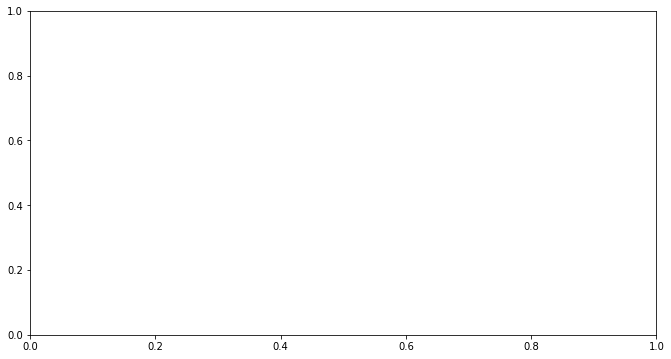

In [13]:
%%time
%matplotlib inline
torch.cuda.empty_cache()
# Deep copy in order to train the network with the same initialized weights
trained_net = Net().to(device)

# set loss function for the net
trained_net.criterion = nn.CrossEntropyLoss(ignore_index=-1)
# You can change the number of EPOCHS
EPOCH = 200

# switch to train mode (original untrained_net was set to eval mode)
trained_net.train()

optimizer = get_optimizer(trained_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(train_loader, trained_net, optimizer, loss_graph, device)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for trained  net')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))

In [20]:
torch.cuda.empty_cache()

t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(f)

2231238144


In [14]:
def validate(val_loader, net):
    iou_arr = []
    val_loss = 0
    
    net.eval()
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            img, gt_seg_img = data.to(device), target.to(device)
            
            output = net(img)
            
            if device != 'cpu':
                output = output.cpu()
                gt_seg_img = gt_seg_img.cpu()
            pred = torch.argmax(output, dim=1).numpy()[0]
            
            gt_np = gt_seg_img.numpy()[0]
            
            conf = eval_semantic_segmentation(pred[None], gt_np[None])
            
            iou_arr.append(conf['miou'])
            
    return val_loss, (sum(iou_arr) / len(iou_arr))

In [21]:
val_data = DataLoaderSegmentation('val')
val_loader = DataLoader(val_data, batch_size=1, shuffle=True, num_workers=0)

In [22]:
%%time
print("mIoU over the training dataset:{}".format(validate(train_loader, trained_net)[1]))

C:\Users\Jack Capombassis\miniconda3\envs\carnd-term1\lib\site-packages\chainercv\evaluations\eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
C:\Users\Jack Capombassis\miniconda3\envs\carnd-term1\lib\site-packages\chainercv\evaluations\eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


mIoU over the training dataset:0.4145669716489606
Wall time: 1min 6s


In [23]:
%%time
print("mIoU over the validation dataset:{}".format(validate(val_loader, trained_net)[1]))

mIoU over the validation dataset:0.409587992866767
Wall time: 17.7 s


View count of pixels within each label category:
(array([ 5,  6,  8,  9, 10, 14, 16, 22], dtype=int64), array([  1153,  13387,  49656,   5374,     53,  22098,   7414, 163009],
      dtype=int64))
(array([ 0,  1,  5,  6,  7,  8,  9, 11, 14, 16, 22], dtype=int64), array([14680, 88465,  5388, 34156,  2349, 36400,    42,  4006, 10191,
       10539, 55928], dtype=int64))
View count of pixels within each label category:
(array([ 1,  5,  6,  7, 10], dtype=int64), array([ 15203, 141988,  50244,  53424,   1285], dtype=int64))
(array([ 1,  4,  5,  6,  7, 22], dtype=int64), array([ 11503,     18, 142395,  72082,  36097,     49], dtype=int64))
View count of pixels within each label category:
(array([ 0,  7, 11, 16, 17, 20, 22], dtype=int64), array([61208, 34335, 73699, 31635, 58411,  1252,  1604], dtype=int64))
(array([ 0,  1,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 22],
      dtype=int64), array([74031,  1693,  5803, 16073, 54218,  1388,  3850,  1922, 12267,
        8231,   199,  

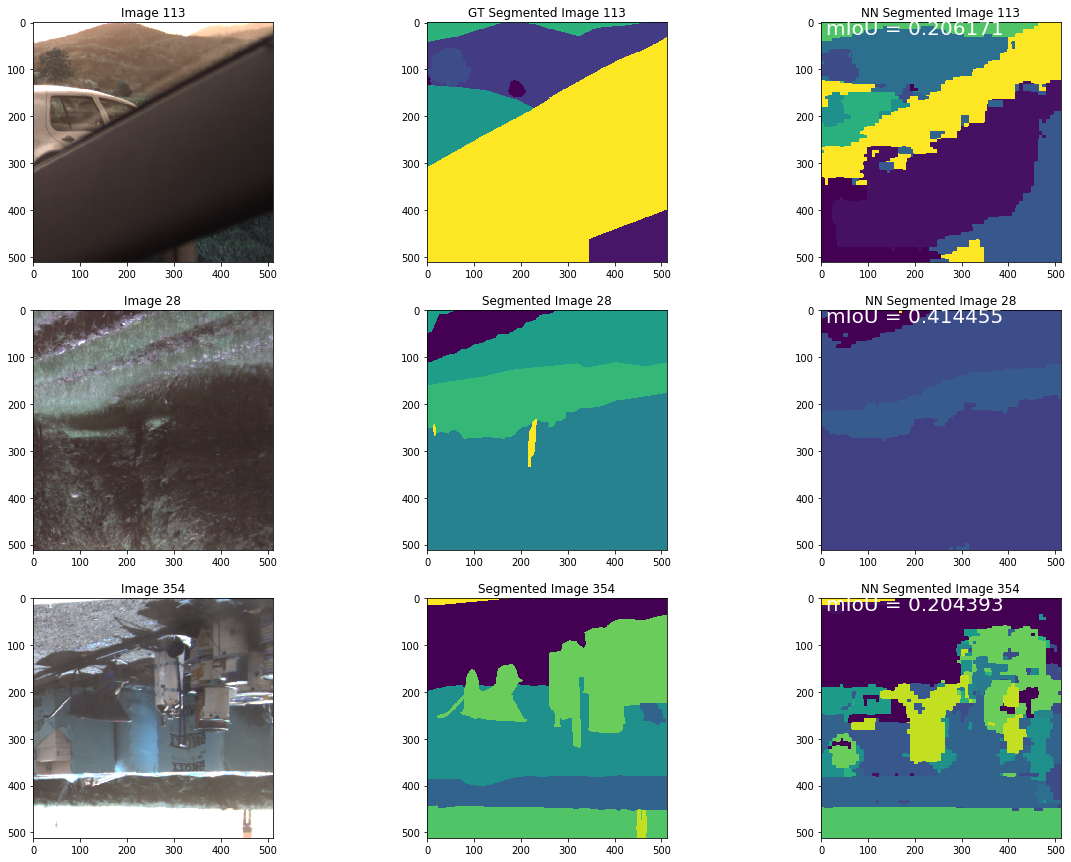

In [28]:
trained_net.eval()

def add_img_txt_plot(fig, index, img, title, sub_plot_id, txt):
    ax = fig.add_subplot(sub_plot_id[0],sub_plot_id[1],sub_plot_id[2])
    plt.title(title + str(index))
    ax.text(10, 25, 'mIoU = {:_>8.6f}'.format(txt), fontsize=20, color='white')
    ax.imshow(img)
    
def get_nn_seg_img(net, img, mask):
    img, get_seg_img = img, mask
    
    nn_seg_output = net.forward(img[None].cuda())
    
    if device != 'cpu':
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).cpu().numpy()[0]
    else:
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).numpy()[0]
        
    gts = get_seg_img.cpu().numpy()
    
    conf = eval_semantic_segmentation(nn_seg_img[None], gts[None])
    
    print("View count of pixels within each label category:")
    print(np.unique(get_seg_img, return_counts=True))
    print(np.unique(nn_seg_img, return_counts=True))
    
    return nn_seg_img, conf['miou']


img_113, seg_img_113 = val_data[20]
img_28, seg_img_28 = train_data[9]
img_354, seg_img_354 = train_data[100]

nn_seg_img_113, miou_113 = get_nn_seg_img(trained_net, img_113, seg_img_113)
nn_seg_img_28, miou_28 = get_nn_seg_img(trained_net, img_28, seg_img_28)
nn_seg_img_354, miou_354 = get_nn_seg_img(trained_net, img_354, seg_img_354)


fig = plt.figure(figsize=(20,15))

add_img_plot(fig, 113, np.rollaxis(img_113.numpy().astype(int), 0, 3), 'Image ', [3,3,1])
add_img_plot(fig, 113, colorize_mask(seg_img_113), 'GT Segmented Image ', [3,3,2])
add_img_txt_plot(fig, 113, colorize_mask_nn_output(nn_seg_img_113), 'NN Segmented Image ', [3,3,3], miou_113)
add_img_plot(fig, 28, np.rollaxis(img_28.numpy().astype(int), 0, 3), 'Image ', [3,3,4])
add_img_plot(fig, 28, colorize_mask(seg_img_28), 'Segmented Image ', [3,3,5])
add_img_txt_plot(fig, 28, colorize_mask_nn_output(nn_seg_img_28), 'NN Segmented Image ', [3,3,6], miou_28)
add_img_plot(fig, 354, np.rollaxis(img_354.numpy().astype(int), 0, 3), 'Image ', [3,3,7])
add_img_plot(fig, 354, colorize_mask(seg_img_354), 'Segmented Image ', [3,3,8])
add_img_txt_plot(fig, 354, colorize_mask_nn_output(nn_seg_img_354), 'NN Segmented Image ', [3,3,9], miou_354)


In [25]:
test_data = DataLoaderSegmentation('test')

View count of pixels within each label category:
(array([ 1,  5,  6,  7,  8, 16], dtype=int64), array([  9217,   9238,  39144, 180745,  15428,   8372], dtype=int64))


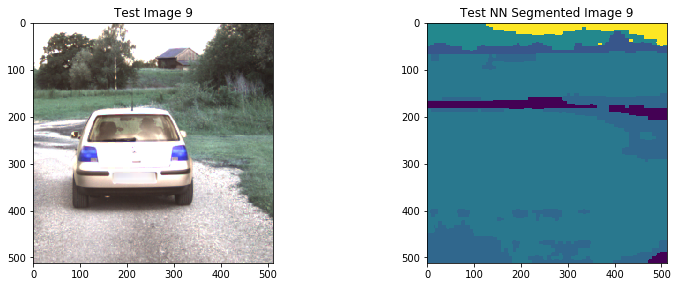

In [26]:
def get_nn_seg_img_test(net, data):
    img = data

    nn_seg_output = net.forward(img[None].cuda())

    if device != 'cpu':
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).cpu().numpy()[0]
    else:
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).numpy()[0]

    print("View count of pixels within each label category:")
    print(np.unique(nn_seg_img, return_counts=True))

    return nn_seg_img

test_img_9 = test_data[9]

test_nn_seg_img_9 = get_nn_seg_img_test(trained_net, test_data[9])

fig = plt.figure(figsize=(20,15))

add_img_plot(fig, 9, np.rollaxis(test_img_9.numpy().astype(int), 0, 3),'Test Image ', [3,3,1])
add_img_plot(fig, 9, colorize_mask_nn_output(test_nn_seg_img_9), 'Test NN Segmented Image ', [3,3,2])

In [31]:
torch.cuda.empty_cache()

t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(f)

1562389504
